# 2. Pre-processing

> Author: *Valentin Christiaens*  
> Suitable for VIP *v1.1.3* onwards  
> Last update: *06/06/2024*

**Table of contents**

* [2.1. Pre-processing a coronagraphic VLT/NACO datacube](#2.1.-Pre-processing-a-coronagraphic-VLT/NACO-datacube)
    - [2.1.1. Loading the data](#2.1.1.-Loading-the-data)
    - [2.1.2. Recentering with individual 2D negative Gaussian fits](#2.1.2.-Recentering-with-individual-2D-negative-Gaussian-fits)
    - [2.1.3. Recentering with cross-correlation + 2D negGaussian](#2.1.3.-Recentering-with-cross-correlation-+-2D-negGaussian)
    - [2.1.4. Recentering with iterative speckle cross-correlation in log-space + 2D negGaussian](#2.1.4.-Recentering-with-iterative-speckle-cross-correlation-in-log-space-+-2D-negGaussian)
    - [2.1.5. Validation of the best recentering method](#2.1.5.-Validation-of-the-best-recentering-method)    
    - [2.1.6. Bad frame trimming](#2.1.6.-Bad-frame-trimming) 
* [2.2. Pre-processing a coronagraphic VLT/SPHERE-IFS datacube](#2.2.-Pre-processing-a-coronagraphic-VLT/SPHERE-IFS-datacube)
    - [2.2.1. Loading the data](#2.2.1.-Loading-the-data)
    - [2.2.2. Replacing NaN values](#2.2.2.-Replacing-NaN-values)
    - [2.2.3. Bad pixel correction](#2.2.3.-Bad-pixel-correction)
    - [2.2.4. Background-star removal](#2.2.4.-Background-star-removal)
    - [2.2.5. Satellite-spot based recentering](#2.2.5.-Satellite-spot-based-recentering)
    - [2.2.6. Radon-transform based recentering](#2.2.6.-Radon-transform-based-recentering)
* [2.3. Pre-processing a VLT/SINFONI datacube](#2.3.-Pre-processing-a-SINFONI-datacube)
    - [2.3.1. Loading the data](#2.3.1.-Loading-the-data)
    - [2.3.2. FWHM measurement](#2.3.2.-FWHM-measurement)
    - [2.3.3. Bad pixel correction](#2.3.3.-Bad-pixel-correction)
    - [2.3.4. Vertical resampling](#2.3.4.-Vertical-resampling)
    - [2.3.5. Recentering with 2D Gaussian fits](#2.3.5.-Recentering-with-2D-Gaussian-fits)

The subpackage ``preproc`` contains all sorts of image transformation routines: translation, rotation, cropping, scaling/resampling, etc. It also contains functions dedicated to the preparation of 3D or 4D arrays before stellar halo modeling and subtraction (i.e. before post-processing), such as bad pixel correction, accurate centering of the star and bad frame trimming. In this tutorial we'll show how to use some of these pre-processing routines to perform the following tasks: 
- recentering a NACO L' coronagraphic dataset and trimming bad frames out of it;
- correcting bad pixels from a SPHERE/IFS coronagraphic datacube and recentering it; 
- performing a "full pre-processing" of a non-coronagraphic SINFONI spectral cube.

It is recommended to perform (first-stage) calibration tasks such as dark subtraction or flat-fielding using the observatory pipeline of the respective instrument the data were acquired with, *before* using the pre-processing routines of VIP. The only potential exception would be for the use of the PCA-based sky-subtraction routine implemented in VIP, `vip.preproc.cube_subtract_sky_pca`, which is not showcased in this tutorial but typically outperforms classical median-sky subtraction at thermal IR wavelengths (e.g. [Hunziker et al. 2018](https://ui.adsabs.harvard.edu/abs/2018A%26A...611A..23H/abstract)).

-----------

Let's first import a couple of external packages needed in this tutorial:

In [1]:
%matplotlib inline
from hciplot import plot_frames, plot_cubes
from matplotlib.pyplot import *
from matplotlib import pyplot as plt
import numpy as np
from packaging import version

In the following box we check you have the required VIP version installed to be able to run this notebook:

In [2]:
import vip_hci as vip

vvip = vip.__version__
print("VIP version: ", vvip)
if version.parse(vvip) < version.parse("1.3.1"):
    msg = "Please upgrade your version of VIP"
    msg+= "It should be 1.3.1 or above to run this notebook."
    raise ValueError(msg)

VIP version:  1.6.2


```{important}
Your version of VIP should be >=1.3.1 to run this notebook. If not, close the notebook and run for example `pip install vip_hci --upgrade` in your terminal.
```

## 2.1. Pre-processing a coronagraphic VLT/NACO datacube

Before using ADI-based post-processing algorithms, it is critical to have the star accurately aligned at the center of all frames of the datacube, a task that can be particularly difficult for coronagraphic observations. This crucial step can however significantly increase the S/N of a putative companion in post-processed images. 

``preproc`` includes several re-centering functions, whose use will depend on the data at hand:

- ``cube_recenter_2dfit`` for positive or negative 2D Gaussian/Moffat/Airy fits to the PSF;
- ``cube_recenter_dft_upsampling`` which aligns the images based on maximizing the cross-correlation of the DFT (Guizar et al. 2008), and recenter the star based on a 2D fit (first function);
- ``cube_recenter_radon`` which recenters the star based on the Radon transform ([Pueyo et al. 2015](https://ui.adsabs.harvard.edu/abs/2015ApJ...803...31P/abstract)); 
- ``cube_recenter_satspots`` which recenters the star  based on the location of 4 satellite-spots - the star being at the center of the spots (standard e.g. for VLT/SPHERE data);
- ``cube_recenter_via_speckles`` which first aligns frames with respect to each other based on maximizing the cross-correlation of speckles, expressed in log scale after low/high-pass filtering, and then fit a positive or negative (for coronagraphic images) 2D Gaussian to the median image of the aligned cube to recenter all frames. This 2-step process is then repeated for several iterations.

### 2.1.1. Loading the data

In the 'datasets' folder of the `VIP_extras` repository you can find a toy ADI (Angular Differential Imaging) cube and a non-coronagraphic point spread function (PSF) to demonstrate the capabilities of ``VIP``. This is an L'-band VLT/NACO dataset of beta Pictoris published in [Absil et al. (2013)](https://ui.adsabs.harvard.edu/abs/2013A%26A...559L..12A/abstract) obtained using the Annular Groove Phase Mask (AGPM) Vortex coronagraph. The sequence has been heavily sub-sampled temporarily to make it smaller. The frames were also cropped to the central 101x101 area. In case you want to plug-in your cube just change the path of the following cells.

More info on this dataset is available in Tutorial `1. Quick start`.

Note that here we load the *not yet well-centered* ADI cube (`cube.fits` suffix instead of `cube_cen.fits`):

In [3]:
from vip_hci.fits import open_fits
from astropy.utils.data import download_file

url_d = "https://github.com/vortex-exoplanet/VIP_extras/raw/master/datasets"
f1 = download_file("{}/naco_betapic_cube.fits".format(url_d), cache=True)
f2 = download_file("{}/naco_betapic_psf.fits".format(url_d), cache=True)
f3 = download_file("{}/naco_betapic_derot_angles.fits".format(url_d), cache=True)

# alternatively, for local files simply provide their full or relative path. E.g.:
#f1 = '../datasets/naco_betapic_cube.fits'
#f2 = '../datasets/naco_betapic_psf.fits'
#f3 = '../datasets/naco_betapic_derot_angles.fits'

cube_orig = open_fits(f1)
psf = open_fits(f2)
angs = open_fits(f3)

FITS HDU-0 data successfully loaded. Data shape: (61, 101, 101)
FITS HDU-0 data successfully loaded. Data shape: (39, 39)
FITS HDU-0 data successfully loaded. Data shape: (61,)


Let's fit the non-coronagraphic PSF with a 2D Gaussian to infer the FWHM, the flux in a 1-FWHM size aperture, and get a flux-normalized PSF:

In [4]:
from vip_hci.fm import normalize_psf

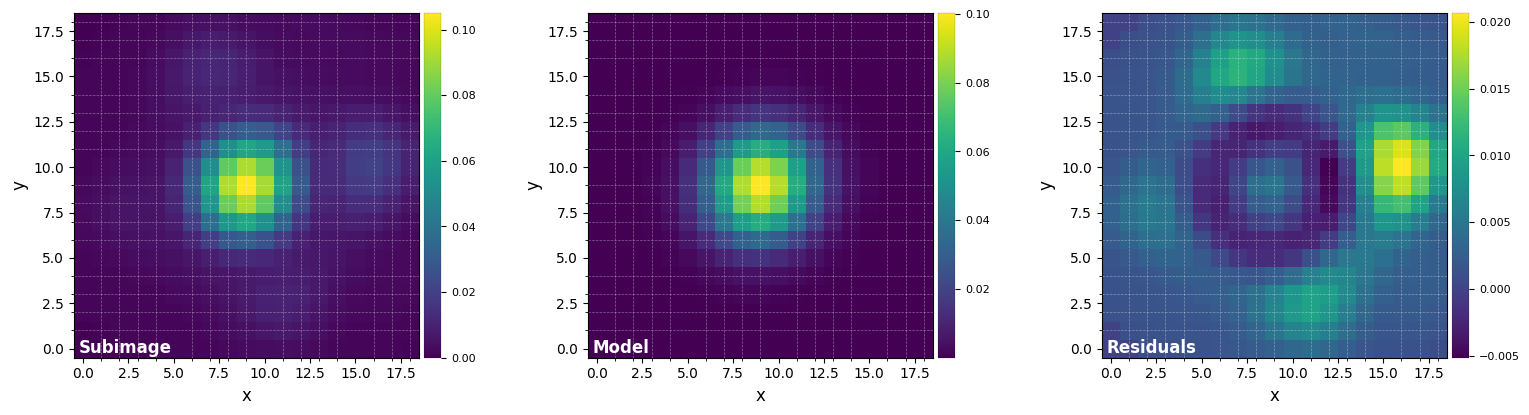

FWHM_y = 4.926059872957138
FWHM_x = 4.675778895005929 

centroid y = 9.010992107833063
centroid x = 9.01917912265807
centroid y subim = 9.010992107833063
centroid x subim = 9.01917912265807 

amplitude = 0.10032285220380603
theta = -38.446187060503874

Mean FWHM: 4.801
Flux in 1xFWHM aperture: 1.307
4.800919383981533


In [5]:
%matplotlib inline
psfn, flux, fwhm_naco = normalize_psf(psf, size=19, debug=True, full_output=True)
print(fwhm_naco)

Let's visualize the normalized PSF with `hciplot.plot_frames`. Feel free to adapt the `backend` argument throughout the notebook: `'matplotlib'` allows paper-quality figures with annotations which can be saved (default), while `'bokeh'` enables interactive visualization.

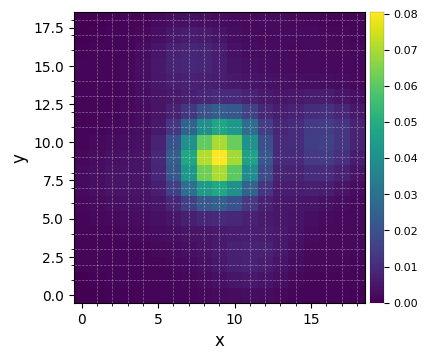

In [6]:
plot_frames(psfn, grid=True, size_factor=4)

Let's define the pixel scale for NACO (L' band), which we get from a dictionary stored in the `config` subpackage:

In [7]:
from vip_hci.config import VLT_NACO

pxscale_naco = VLT_NACO['plsc']
print(pxscale_naco, "arcsec/px")

0.02719 arcsec/px


Now let's have a look at one single image of our toy datacube. We see that the dark hole is clearly off-center:

New shape: (15, 15)


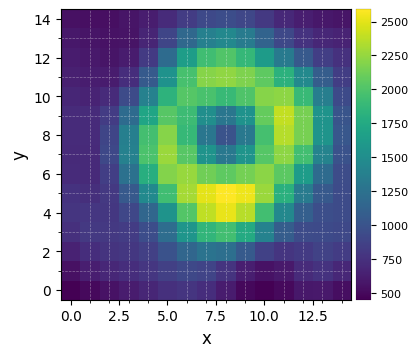

In [8]:
from vip_hci.preproc import frame_crop

plot_frames(frame_crop(cube_orig[0], 15), grid=True, size_factor=4)  # plotting a cropped subimage

For this NACO+AGPM dataset, three approaches could be considered for recentering - all assuming that the average location of the star throughout the observation coincides with the sweet spot (dark hole) of the coronagraph: 

### 2.1.2. Recentering with individual 2D negative Gaussian fits

This approach consists in fitting a negative 2D Gaussian model to the dark hole area for each individual image. The coordinates of the centroid of the negative 2D Gaussian are then used to shift and align all images.

If using a different datacube, you may need to adjust:

- the position `xy` of the approximate center of the coronagraphic PSF (if `xy` is not provided, the function will consider a subimage at the center of the input cube images);
- the `subi_size` (sub-image size used for the Gaussian fit, in pixels);
- a first-guess value for the `fwhm` (or the measured value returned by `normalize_psf`);
- `negative` which tells the function whether to fit a negative or positive Gaussian (i.e., False for non-coronagraphic PSFs).

Only use the `debug` mode on small datacubes (less than 20 frames), e.g. on a small subset of your datacube.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-10-25 12:21:48
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
2d gauss-fitting
frames
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Shifting
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Running time:  0:00:00.418457
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


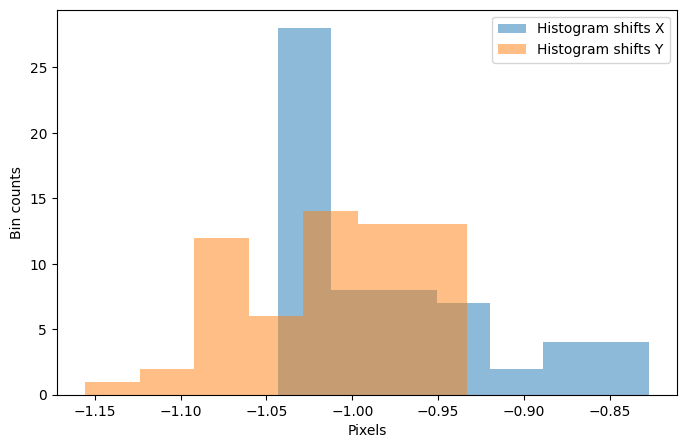

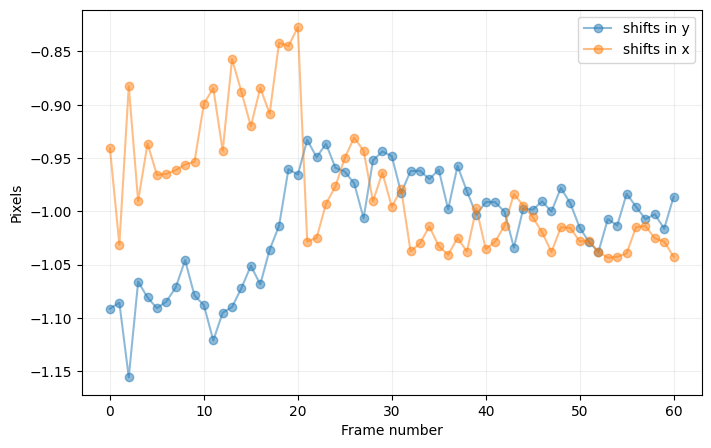

In [9]:
from vip_hci.preproc import cube_recenter_2dfit

cube1, shy1, shx1 = cube_recenter_2dfit(cube_orig, xy=(51, 51), fwhm=fwhm_naco, subi_size=5, 
                                        model='gauss', negative=True, full_output=True)

### 2.1.3. Recentering with cross-correlation + 2D negGaussian

This approach is a two-step procedure involving i) a cross-correlation based method in the Fourier plane used for alignment of the images with respect to the first one, and ii) fitting of a negative 2D gaussian to the mean of the aligned cube for final centering.

The `cube_recenter_dft_upsampling` function implements both steps consecutively, with the `upsample_factor` controlling the requested level of precision (e.g. 100 implies a precision of 1/100 px) for the alignment in the first step, and with the second step optionally triggered by setting the `subi_size` parameter to an integer (by default it is None, hence only relative image alignment is done but not *centering of the star*).

When `subi_size` is set to an integer, it corresponds to the size of the box used to fit a 2D gaussian to the mean image of the aligned cube, where all frames were aligned with respect to the first one. In this case, `center_fr1` can also be provided and should correspond to the rough coordinates of the centroid *in the first image*, around which a subimage is cropped for the 2D Gaussian fit in the mean image of the aligned cube.

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-10-25 12:21:48
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Shift for first frame X,Y=(-0.985, -0.652)
The rest of the frames will be shifted by cross-correlation wrt the 1st
Running time:  0:00:03.522359
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Shifts required to align the frames of the cube with respect to the first one:


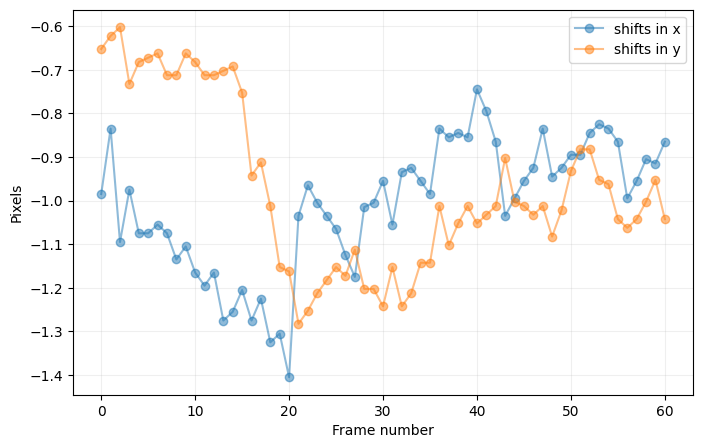

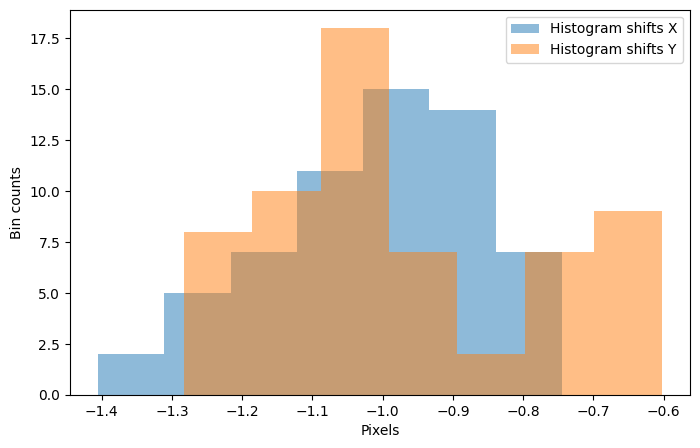

In [10]:
from vip_hci.preproc import cube_recenter_dft_upsampling

cube2, shy2a, shx2a = cube_recenter_dft_upsampling(cube_orig, upsample_factor=100,
                                                   subi_size=5, center_fr1=(51, 51), 
                                                   fwhm=fwhm_naco, negative=True,
                                                   full_output=True, debug=False)

print("Shifts required to align the frames of the cube with respect to the first one:")
plt.show()

### 2.1.4. Recentering with iterative speckle cross-correlation in log-space + 2D negGaussian

This third approach is similar to the previous one but is iterative, involving two steps at each iteration:

i) the images of the cube are aligned with respect to each other based on cross-correlation of the speckles *in log-scale intensity* images (log scale to better capture fainter speckle at larger radius);

ii) a 2D negative Gaussian is fitted to the median image of the aligned cube, and used to recenter the cube.

By default, it involves 5 iterations (set with `alignment_iter`). Since the cross-correlation is done in log-scale, it is important to set a crop size (with `subframesize`) corresponding to the rough extent of the stellar halo, to avoid being biased by background noise. This procedure is well suited for coronagraphic data where an extended speckle pattern can be seen in the images in log scale, and where the imprint of the coronagraph can be represented by a reversed Gaussian (e.g. NIRC2+AGPM, NACO+AGPM or ERIS+AGPM).

Sub frame shape: (61, 35, 35)
Center pixel: (17, 17)
Square sum of shift vecs: 90.1633503105065
Square sum of shift vecs: 1.9922979040480582
Square sum of shift vecs: 0.25
Square sum of shift vecs: 0.09
Square sum of shift vecs: 0.0


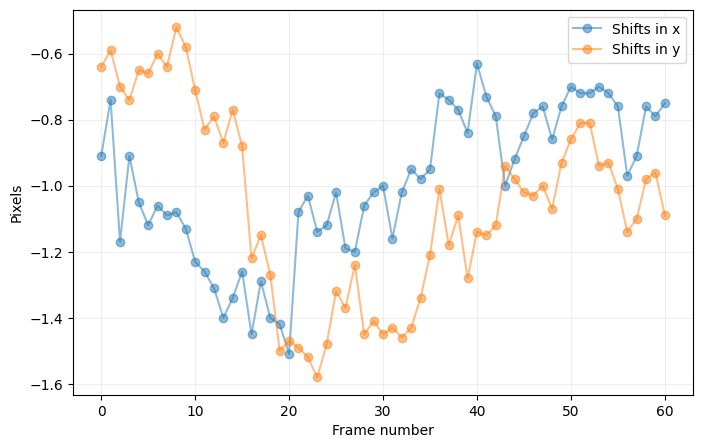

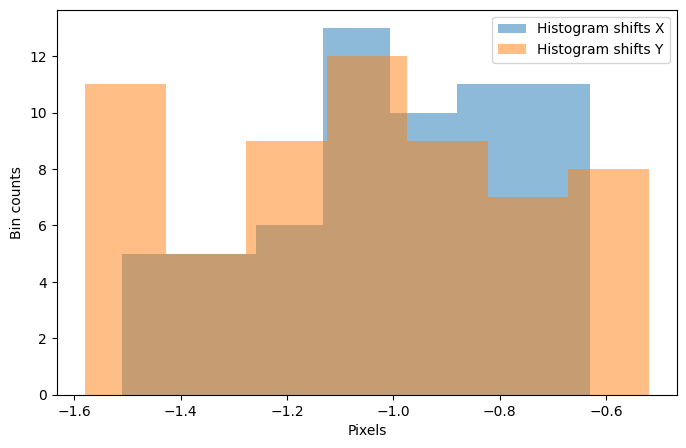

In [11]:
from vip_hci.preproc import cube_recenter_via_speckles

cube3, _, _, shy3, shx3 = cube_recenter_via_speckles(cube_orig, alignment_iter=5, fwhm=fwhm_naco, debug=False, 
                                                     recenter_median=True, fit_type='gaus', negative=True, 
                                                     crop=True, subframesize=35, mask=None, 
                                                     max_spat_freq=5, plot=True, full_output=True)

### 2.1.5. Validation of the best recentering method

Frame re-centering is a case-dependent procedure. Since for this dataset there is a known companion, we can use it to infer the performance of each recentering method. All other pre-processing steps being identical, the S/N ratio of the companion is expected to be higher with PCA-ADI (with 1 principal component used) for the cube with the best centering for the star. Not only is the companion expected to stack up in a more constructive way after derotation, but the modeling and subtraction of speckles may be slightly better if the images are perfectly aligned.

Let's post-process each cube with PCA (ncomp=1 by default), and measure the S/N ratio of Beta Pic b:

In [12]:
from vip_hci.psfsub import pca

fr1 = pca(cube1, angs)
fr2 = pca(cube2, angs)
fr3 = pca(cube3, angs)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-10-25 12:22:09
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 2.966 GB
Done vectorizing the frames. Matrix shape: (61, 10201)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.547091
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:00:02.926772
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-10-25 12:22:12
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 2.907 GB
Done vectorizing the frames. Matrix shape: (61, 10201)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.630337
―――――

Let's visualize the final images:

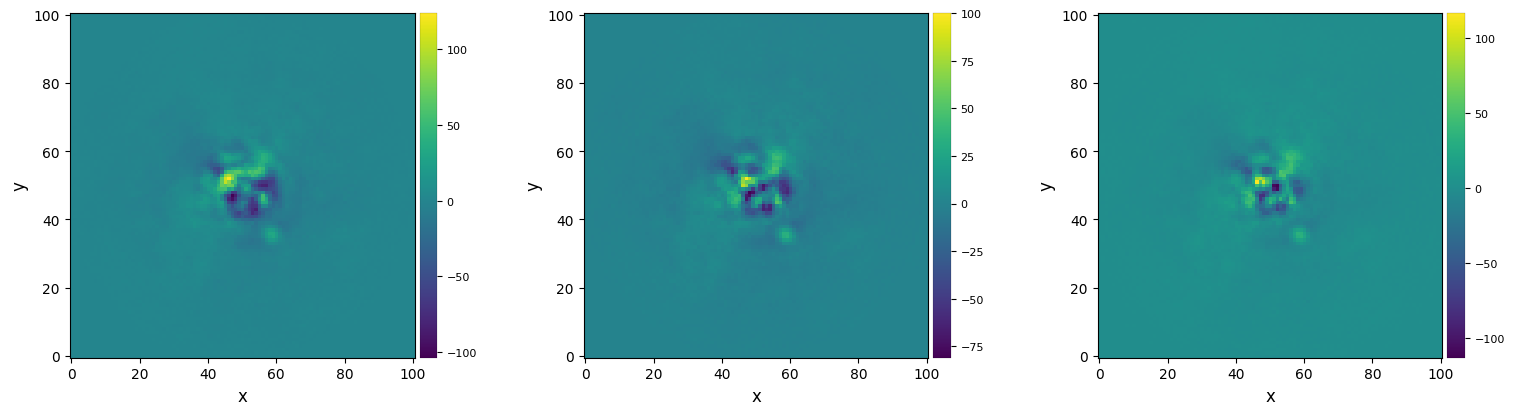

In [13]:
plot_frames((fr1, fr2, fr3))#, backend='bokeh')

Let's write down the coordinates of the point source:

In [14]:
xy = (58.6, 35.4)

Now let's measure the S/N ratio of the companion in each case:

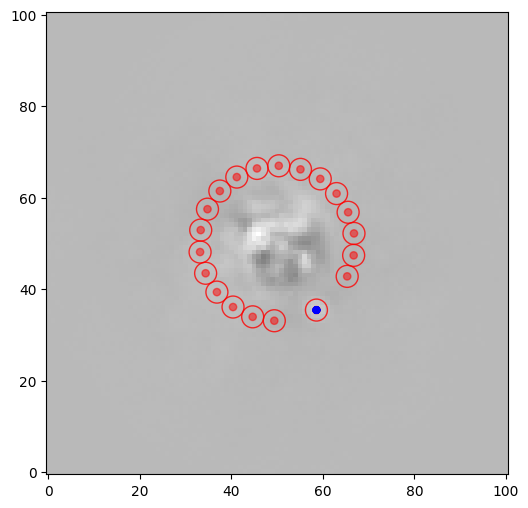

In [15]:
from vip_hci.metrics import snr

snr1 = snr(fr1, xy, fwhm_naco, exclude_negative_lobes=True, plot=True)
snr2 = snr(fr2, xy, fwhm_naco, exclude_negative_lobes=True, plot=False)
snr3 = snr(fr3, xy, fwhm_naco, exclude_negative_lobes=True, plot=False)

```{note}
In post-processed images obtained with ADI-based algorithms, a real companion will look like a positive blob encased between 2 adjacent negative lobes. While the classical SNR definition does not bother with these negative lobes, their inclusion in the test apertures used to estimate the noise can in practice lead to an underestimation of the SNR. 
The `snr` and `snrmap` function in VIP allows the exclusion of these lobes through the `exclude_negative_lobes` arguments (more details in [Tutorial 4](https://vip.readthedocs.io/en/latest/tutorials/04_metrics.html)).
```

In [16]:
print(round(snr1, 1), round(snr2, 1), round(snr3,1))

3.0 3.4 3.4


The second and third methods appear to lead to a slightly better S/N ratio for Beta Pic b, although it is fair to mention that all of them yield S/N values in the same ballpark. 

```{important}   
Based on our experience with different AGPM datasets, the **iterative speckle-correlation based alignment + negative 2D Gaussian fit** method is the one we recommend to use to recenter vortex/AGPM data.
```

In [17]:
cube_cen = cube3

### 2.1.6. Bad frame trimming

ADI-based post-processing algorithms rely on *angular diversity* to produce a PSF model and subtract it from each image of the datacube: a putative planet rotates in the image while the stellar PSF is expected to be *mostly* static. The more stable the PSF in the image sequence, the better post-processing algorithms can leverage this. For observations in highly stable conditions, a simple median image of the cube may be a good enough PSF model for subtraction.

Considering the above, an optimal reduction+post-processing pipeline should involve trimming bad frames. In VIP, several functions have been implemented to tackle this task:

- `cube_detect_badfr_ellipticity` to reject bad frames based on the ellipticity of the PSF;
- `cube_detect_badfr_pxstats` to reject bad frames based on pixel intensity statistics in a given area of the image;
- `cube_detect_badfr_correlation` to reject bad frames based on some measure of the cross-correlation or distance to a good frame.

By default, we recommend using the *cross-correlation* (or *distance*) criterion, in particular for algorithms involving a low-rank approximation of the image cube. Let's try it out on our Beta Pic dataset, and see how trimming bad frames can affect the S/N ratio of the companion.

One can use the median image of the sequence as reference (as shown below), or the index of a good frame in the cube:

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-10-25 12:22:18
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done detecting bad frames from cube: 19 out of 61 (31.1%)
Running time:  0:00:00.029086
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


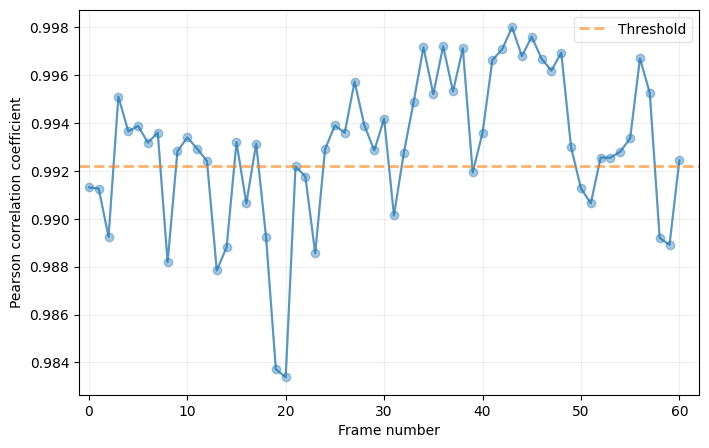

In [18]:
from vip_hci.preproc import cube_detect_badfr_correlation

good_idx_p, bad_idx_p = cube_detect_badfr_correlation(cube_cen, frame_ref=np.median(cube_cen,axis=0), 
                                                      crop_size=31, dist='pearson', percentile=30, 
                                                      threshold=None, plot=True, verbose=True)

By default a (centered) cropped image is used for the calculation (crop size set by `crop_sz`) of the Pearson correlation coefficient (PCC; `dist='pearson'`); although other metrics can be used. In practice, the inner most part of the image (either saturated or hidden by a coronagraphic mask) is usually not relevant, so it can be preferable to use an annular region for the calculation, set by `mode='annulus'`, the annulus being defined with `inradius` and `width`.

The bad frame rejection can be based either on a requested percentile (e.g. `percentile=30` means only the 70% most correlated frames are kept) or absolute `threshold` (if both are provided, `threshold` takes precedence).

Let's try an absolute threshold of 0.985 in an annular region encompassing the planet, and let's consider frame #42 as the reference frame:

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-10-25 12:22:18
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done detecting bad frames from cube: 25 out of 61 (41.0%)
Running time:  0:00:00.035012
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


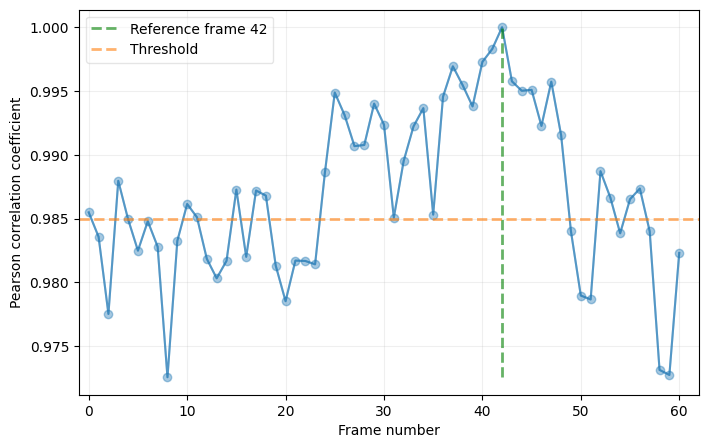

In [19]:
good_idx_t, bad_idx_t = cube_detect_badfr_correlation(cube_cen, frame_ref=42, #np.median(cube_cen,axis=0), 
                                                      crop_size=31, dist='pearson', threshold=0.985, 
                                                      mode='annulus', inradius=int(fwhm_naco), 
                                                      width=int(4*fwhm_naco), plot=True, verbose=True)

Now let's compare the S/N ratio of the planet obtained after PCA-ADI post-processing on: the non-trimmed cube, the cube trimmed using the PCC in the cropped sub-image, and trimmed using the PCC in an annular region:

Don't forget to trim the associated parallactic angle vector as well:

In [20]:
cube_trim_p = cube_cen[good_idx_p]
angs_trim_p = angs[good_idx_p]

cube_trim_t = cube_cen[good_idx_t]
angs_trim_t = angs[good_idx_t]

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-10-25 12:22:18
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 2.800 GB
Done vectorizing the frames. Matrix shape: (42, 10201)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.228607
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:00:01.900816
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-10-25 12:22:20
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 17.180 GB
System available memory = 2.839 GB
Done vectorizing the frames. Matrix shape: (36, 10201)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.076463
―――――

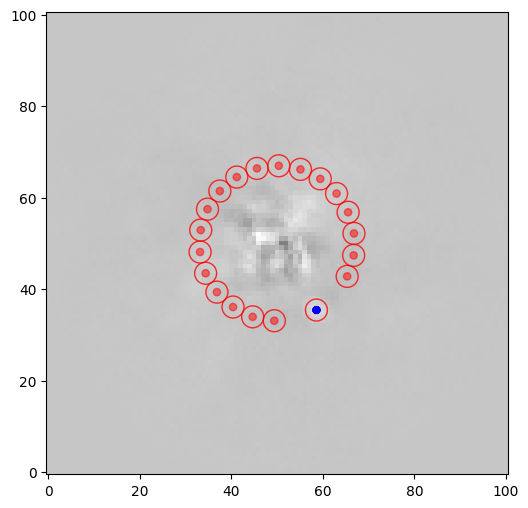

In [21]:
from vip_hci.metrics import snr

fr_trim_p = pca(cube_trim_p, angs_trim_p)
snr_trim_p = snr(fr_trim_p, xy, fwhm_naco, exclude_negative_lobes=True, plot=False)

fr_trim_t = pca(cube_trim_t, angs_trim_t)
snr_trim_t = snr(fr_trim_t, xy, fwhm_naco, exclude_negative_lobes=True, plot=True)

The measured S/N ratio in each of the 3 cases is:

In [22]:
print(round(snr3,1), round(snr_trim_p,1), round(snr_trim_t,1))

3.4 3.5 3.6


We see that appropriate bad frame trimming can indeed increase the S/N ratio of a given companion, for a given number of principal components used.

Feel free to test other distance metrics.

## 2.2. Pre-processing a coronagraphic VLT/SPHERE-IFS datacube

### 2.2.1. Loading the data

In the 'datasets' folder of the `VIP_extras` repository you can find a SPHERE/IFS 'CENTER' spectral cube obtained on PDS 70 on February 24th, 2018 (details in [Müller et al. 2018](https://ui.adsabs.harvard.edu/abs/2018A%26A...617L...2M/abstract)). The images contain 4 satellite spots (located along a 'X' pattern) which can be used to infer the location of the star behind the coronagraph (at the intersection of the diagonals). A non-coronagraphic PSF spectral cube is also available.

The point of this section is to show how to:

- correct for residual bad pixels and NaN values;
- perform a fine centering of the images based on satellite-spots (in the presence of a contaminating background star);
- perform a fine centering based on the Radon transform. 

In [24]:
from vip_hci.fits import open_fits

url_d = "https://github.com/vortex-exoplanet/VIP_extras/raw/master/datasets"
f1 = download_file("{}/sphere_ifs_PDS70_cen.fits".format(url_d), cache=True)
f2 = download_file("{}/sphere_ifs_PDS70_psf.fits".format(url_d), cache=True)
f3 = download_file("{}/sphere_ifs_PDS70_wl.fits".format(url_d), cache=True)

# alternatively, for local files simply provide their full or relative path. E.g.:
#f1 = '../datasets/sphere_ifs_PDS70_cen.fits'
#f2 = '../datasets/sphere_ifs_PDS70_psf.fits'
#f3 = '../datasets/sphere_ifs_PDS70_wl.fits'

cube = open_fits(f1)
psfifs = open_fits(f2)
lbda = open_fits(f3)

FITS HDU-0 data successfully loaded. Data shape: (39, 199, 199)
FITS HDU-0 data successfully loaded. Data shape: (39, 31, 31)
FITS HDU-0 data successfully loaded. Data shape: (39,)


Each IFS spectral cube consists of 39 monochromatic images spread in wavelengths between the Y and J bands ('YJ' mode; 0.9-1.4µm) or Y and H bands ('YJH' mode; 0.9-1.7µm). 

A few 'CENTER' cubes are usually acquired for a given object of interest, either at the beginning and end of the observation, or at regular intervals throughout the observation, while the rest of the spectral cubes are usually obtained without satellite spots. The star location is then inferred in those cubes by linear interpolation of the positions derived in the 'CENTER' cubes.

Given the large size of typical full IFS observations, in this tutorial we only include one 'CENTER' cube, and hence only showcase the actual determination of stellar positions in that specific cube (i.e. no linear interpolation to infer the stellar position in the rest of the observation).

Let's first visualize a few images from the CENTER spectral cube:

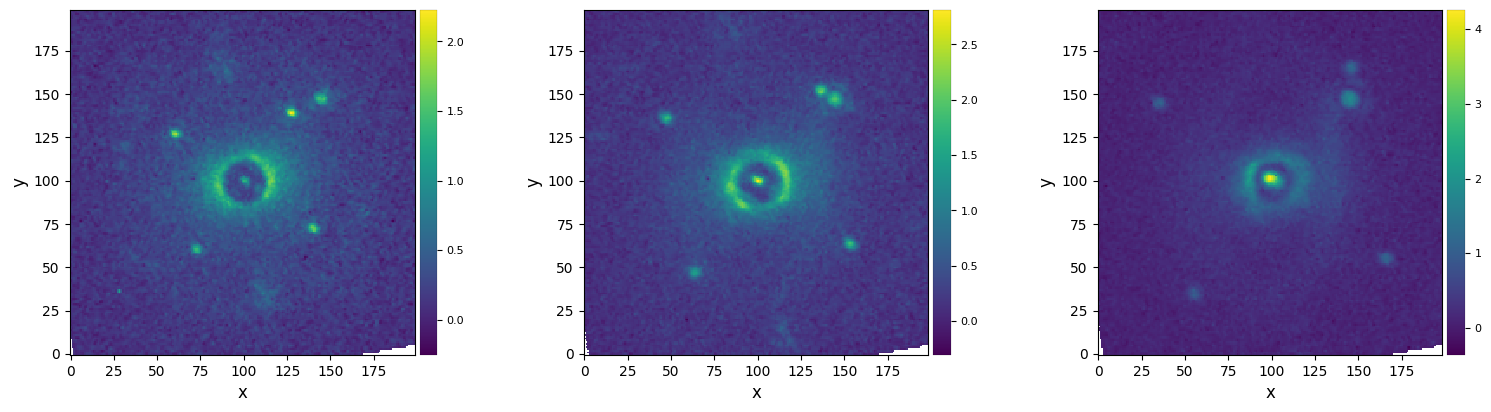

In [25]:
plot_frames((cube[1], cube[19], cube[-1]))

A couple of things can be noted from the inspection of the images:

- the 4 satellite spots are located along a 'x' shape, and expand radially with increasing wavelength;
- a bright background star (not moving radially) is present towards the top right - its close proximity to the top-right satellite spot may interfere with an accurate retrieval of the stellar position;
- a couple of hot/cold/bad pixels remain in the image (e.g. towards the bottom left of the first frame) - these are best seen when opening the images in a FITS viewer;
- there are NaN values in the bottom right corner.

We will therefore proceed with:

1. replacing NaN values;
2. correcting bad pixels;
3. removing a model of the background star;
4. recenter the cube based on the location of the satellite spots (we will see 2 different methods).

### 2.2.2. Replacing NaN values

Some FFT-based image operations in VIP (namely sub-px shifts) do not support NaN values (interpolation-based methods are fine). Let's replace the few NaN values at the bottom right corner of the images right away to avoid any bug during the recentering of the images.

In [26]:
from vip_hci.preproc import cube_correct_nan

cube_nancorr = cube_correct_nan(cube, neighbor_box=5, min_neighbors=5)

The `cube_correct_nan` function replace NaN values by the median of good neighbours, iteratively until all NaN values are corrected. One can increase the box size `neighbor_box`  (less iterations) or reduce the minimum number of good neighbours `min_neighbors` for a faster correction of large chunks of NaN values (consider cropping if located at the edges).

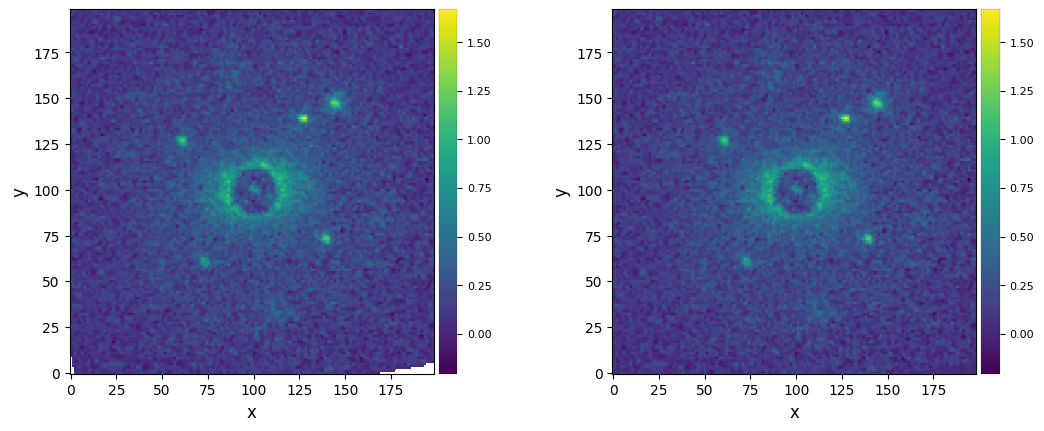

In [27]:
plot_frames((cube[0], cube_nancorr[0]))

```{note}
A better alternative to the quick NaN replacement above, is to (i) create a binary bad pixel map which includes the NaN values (using e.g. `np.isnan`), (ii) add these bad pixels to the bad pixel map inferred through one or more methods detailed in the next section, and (iii) finally proceed with a single correction of all NaN and bad pixels together with the `cube_fix_badpix_interp` routine.
```

### 2.2.3. Bad pixel correction

Several bad pixel correction algorithms are available in VIP:
1. `cube_fix_badpix_isolated`: finds and corrects isolated bad pixels by sigma filtering;
2. `cube_fix_badpix_annuli`: identifies bad pixels in concentric annuli (requires a circularly symmetric PSF), and replace them with the median of the value in the annulus (+ a random value following Poisson distribution);
3. `cube_fix_badpix_clump`: which iteratively identifies bad pixels by sigma filtering, and replace them with the median of good neighour pixels (useful for clumps of bad pixels);
4. `cube_fix_badpix_ifs`: which leverages the radial expansion of the PSF with wavelength in IFS cubes to better identify bad pixels;
5. `cube_fix_badpix_interp`: which corrects bad pixels (provided with an input bad pixel map, e.g. found by one of the first 4 methods) by interpolation using either a 2D Gaussian kernel or the FT-based algorithm described in Aachen & Metzler (2001).

```{note}                                   
To avoid issues in post-processing related to the presence of NaN/bad pixel values, it is recommended to replace them. However it is a good practice to save NaN/bad pixel maps and propagate them during post-processing, e.g. derotate them and then median-combine residual images only where meaningful information is present (i.e. not where values were imputed) for example using `np.nanmedian`.
```

#### 2.2.3.1. Sigma filter

Given that the bad pixels seem to be relatively isolated in the IFS images, let's simply use the first approach (the fastest) in 2 steps. First we correct for static bad pixels, by only looking for bad pixels in the mean image of the cube (`frame_by_frame=False`):

In [28]:
from vip_hci.preproc import cube_fix_badpix_isolated

cube_sigcorr, bpm_mask = cube_fix_badpix_isolated(cube_nancorr, sigma_clip=5, num_neig=9, size=9, 
                                                  frame_by_frame=False, mad=True, verbose=True, 
                                                  full_output=True) 

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-10-25 12:25:21
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
processing frames
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
Done replacing 2418 bad pixels using the median of neighbors
(i.e. 62 static bad pixels per channel))
Running time:  0:00:02.980766
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Next we also catch individual bad pixels (e.g. due to cosmic rays), in addition to the static bad pixels - which are now flagged and not used to identify additional outliers nor to correct them, by providing a `bpm_mask` and requesting `correct_only=False` (which will find additional bad pixels, instead of just correcting the ones in the input `bpm_mask`):

In [29]:
cube_sigcorr, bpm_mask_tmp = cube_fix_badpix_isolated(cube_sigcorr, bpm_mask=bpm_mask, correct_only=False, 
                                                      sigma_clip=5, num_neig=9, size=9, frame_by_frame=True,
                                                      mad=True, verbose=True, full_output=True)
bpm_mask_2d = bpm_mask.copy()
bpm_mask = np.zeros_like(cube_nancorr)
for i in range(cube_nancorr.shape[0]):
    bpm_mask[i] = bpm_mask_2d+bpm_mask_tmp[i]

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-10-25 12:25:24
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
processing frames
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:29
Done replacing 2508 bad pixels using the median of neighbors
Running time:  0:00:29.442529
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


Feel free to adapt:
- the sigma clipping threshold `sigma_clip`,
- the box sizes for outlier identification and median filtering (through `num_neig` and `size`, respectively), and
- the `mad` parameter which determines whether to use standard deviations (False) or median absolute deviations (True) for outlier identification. 

Let's visualize both the static and total individual bad pixel masks (i.e. summed over all spectral channels):

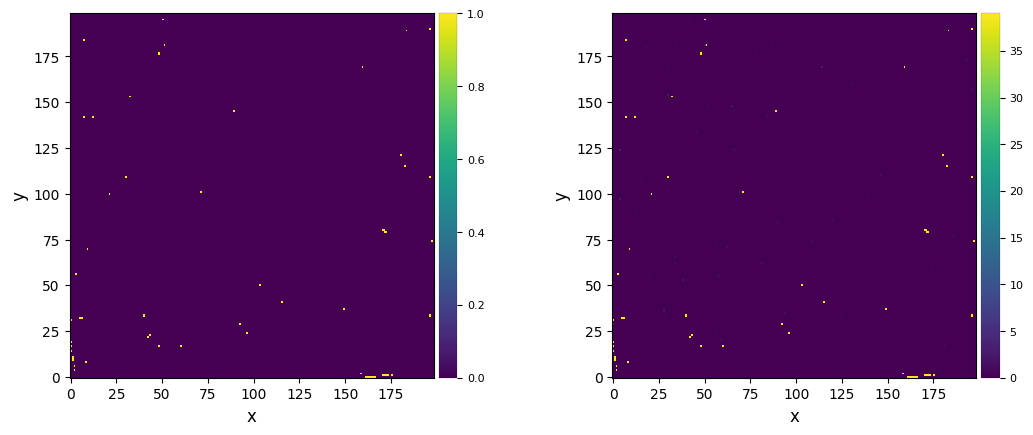

In [30]:
plot_frames((bpm_mask_2d, np.sum(bpm_mask_tmp,axis=0)))

Let's now check one frame of the cube before and after bad pixel correction, and the difference between them:

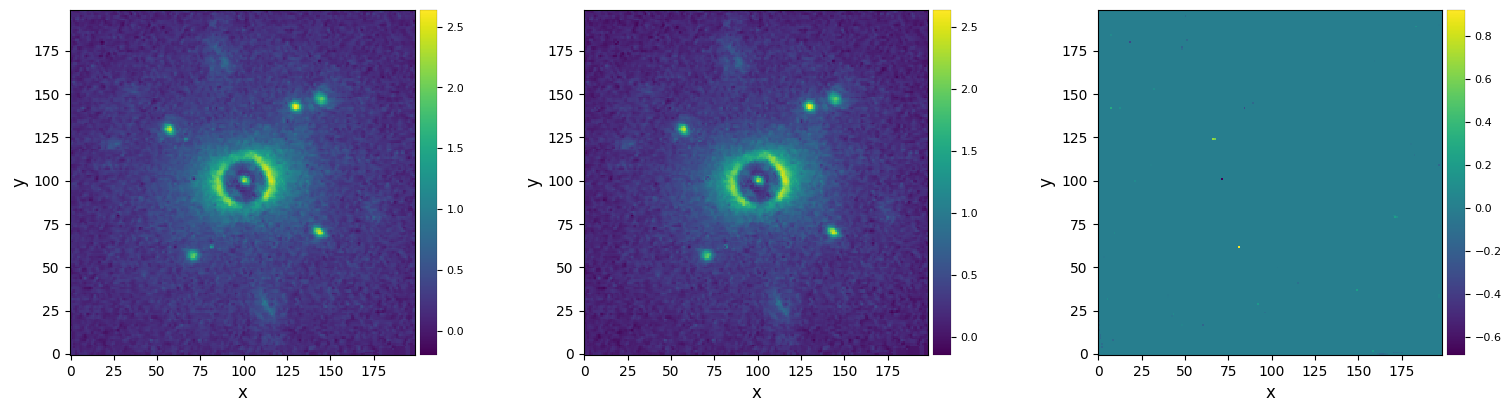

In [31]:
test_idx = 6
plot_frames((cube_nancorr[test_idx], cube_sigcorr[test_idx], cube_nancorr[test_idx]-cube_sigcorr[test_idx]))

```{important}
Bad pixel correction algorithms in VIP have been implemented for compatibility with `numba`. The latter can significantly increase the speed of the bad pixel correction. `numba` is not a mandatory dependency of VIP though, so you have to install it separately, e.g. with `pip install numba`.
```

#### 2.2.3.2. DFT-extrapolation

Another approach, provided a map of bad pixels, is to correct them with an iterative spectral deconvolution algorithm [(Aach & Metzler 2001)](https://ui.adsabs.harvard.edu/abs/2001SPIE.4322..824A/abstract). The observed image with bad pixels can be written as g(x,y) = f(x,y) * w(x,y), where f(x,y) is the original image as it would be seen in absence of bad pixel, and w(x,y) a binary bad pixel mask. The spectral deconvolution method relies on:
- the fact that the FT of a product of 2 functions is equal to the convolution of their respective FT;
- the  estimation of F(u,v), the FT of f(x,y), by iteratively including the most significant spectral lines from G_i(u,v), where G_i(u,v) is set to G(u,v), the FT of g(x,y), at the first iteration, and is then removed from its most significant mode at each subsequent iteration.

This algorithm is available in VIP (v1.3.1 onwards) in `frame_fix_badpix_fft` for 2D images. For 3D cubes, one can use `cube_fix_badpix_interp` with `mode='fft'`. The latter also contains the option to perform a (much faster) correction using a Gaussian kernel interpolation (illustrated in Sec. [2.3.3](#2.3.3.-Bad-pixel-correction)).

Let's illustrate its performance below. We first artificially mask a large block of pixels, and then compare the results obtained with sigma filtering median-neighbour interpolation and DFT-extrapolation to the original pixel intensities:

In [32]:
test_idx = [1, 10, 30] # indices of test frames
#ty0, ty1 = 25, 29      # start and end y coordinates for rectangle of masked pixels # in noise regime
#tx0, tx1 = 159, 165    # start and end x coordinates for rectangle of masked pixels # in noise regime
ty0A, ty1A = 75, 79      # start and end y coordinates for rectangle of masked pixels
tx0A, tx1A = 97, 103    # start and end x coordinates for rectangle of masked pixels
ty0B, ty1B = -79, -75   # start and end y coordinates for rectangle of masked pixels
tx0B, tx1B = 97, 103     # start and end x coordinates for rectangle of masked pixels
ty0C, ty1C = 97, 103     # start and end y coordinates for rectangle of masked pixels
tx0C, tx1C = 120, 124     # start and end x coordinates for rectangle of masked pixels

# collate into lists
ty0 = [ty0A, ty0B, ty0C]
ty1 = [ty1A, ty1B, ty1C]
tx0 = [tx0A, tx0B, tx0C]
tx1 = [tx1A, tx1B, tx1C]

bpm_masks = []
for t in range(len(test_idx)):
    bpm_mask_test = bpm_mask.copy()
    bpm_mask_test[test_idx[t], ty0[t]:ty1[t], tx0[t]:tx1[t]] = 1  # set them as bad pixels even if good
    bpm_masks.append(bpm_mask_test[test_idx[t]])

```{warning}                                   
Iterative spectral deconvolution can yield very good results for bad pixel correction but... is extremely slow! The following cell may take 10-20min to run on a standard laptop.
```

In [33]:
from vip_hci.preproc import cube_fix_badpix_interp, frame_fix_badpix_isolated

# tests
frames_nan = []
frames_fftcorr = []
frames_sigcorr = []

for t in range(len(test_idx)):
    frame_nan = cube_nancorr[test_idx[t]].copy()
    frame_nan[np.where(bpm_masks[t])] = np.nan
    frames_nan.append(frame_nan)
    frame_fftcorr = cube_fix_badpix_interp(cube_nancorr[test_idx[t]], bpm_masks[t], 
                                           tol=10, nit=2000)
    frames_fftcorr.append(frame_fftcorr)
    frame_sigcorr = frame_fix_badpix_isolated(cube_nancorr[test_idx[t]], bpm_masks[t],
                                              sigma_clip=5, num_neig=9, size=9, mad=True, 
                                              verbose=True, full_output=False)
    frames_sigcorr.append(frame_sigcorr)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-10-25 12:25:53
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
iterative bad pixel correction
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:07:00
FFT-interpolation terminated after 2000 iterations (Eg=124.5209810681292)
Running time:  0:07:00.271299
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-10-25 12:32:54
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done replacing 259 bad pixels using the median of neighbors
Running time:  0:00:00.779801
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-10-25 12:32:55
―――――――――――――――――

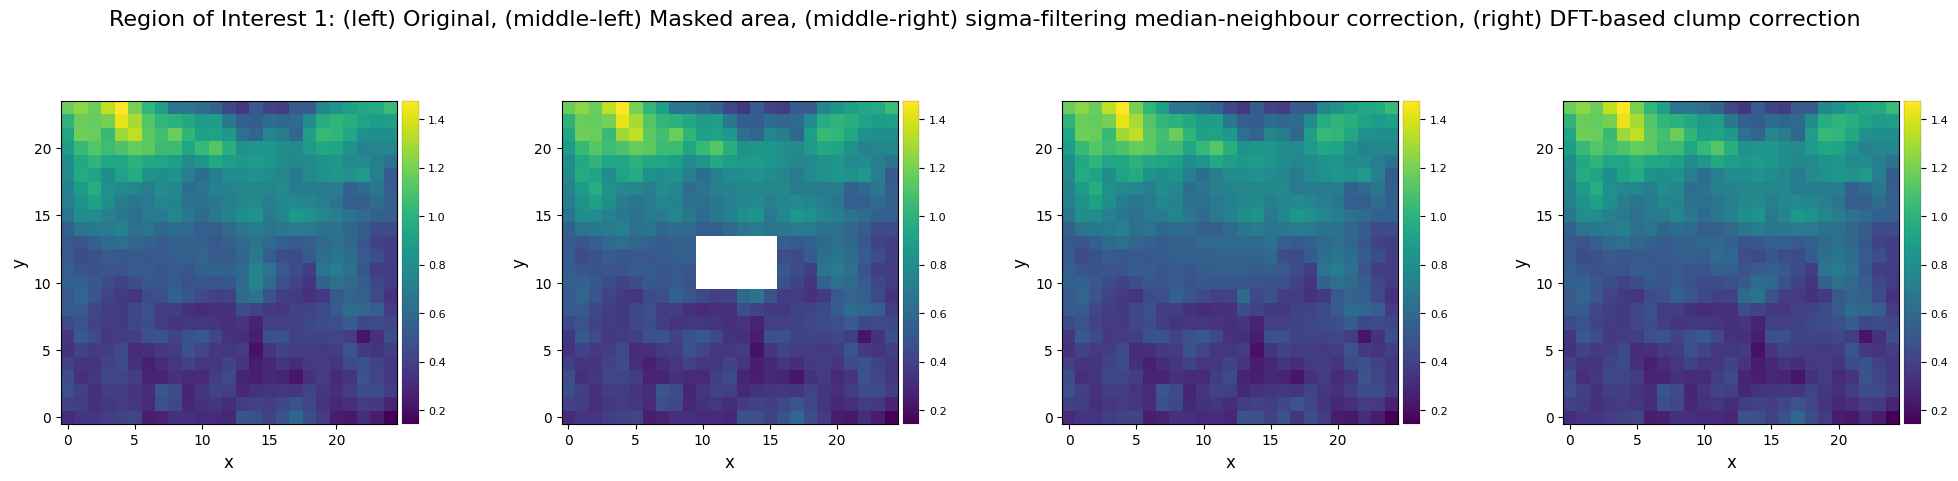

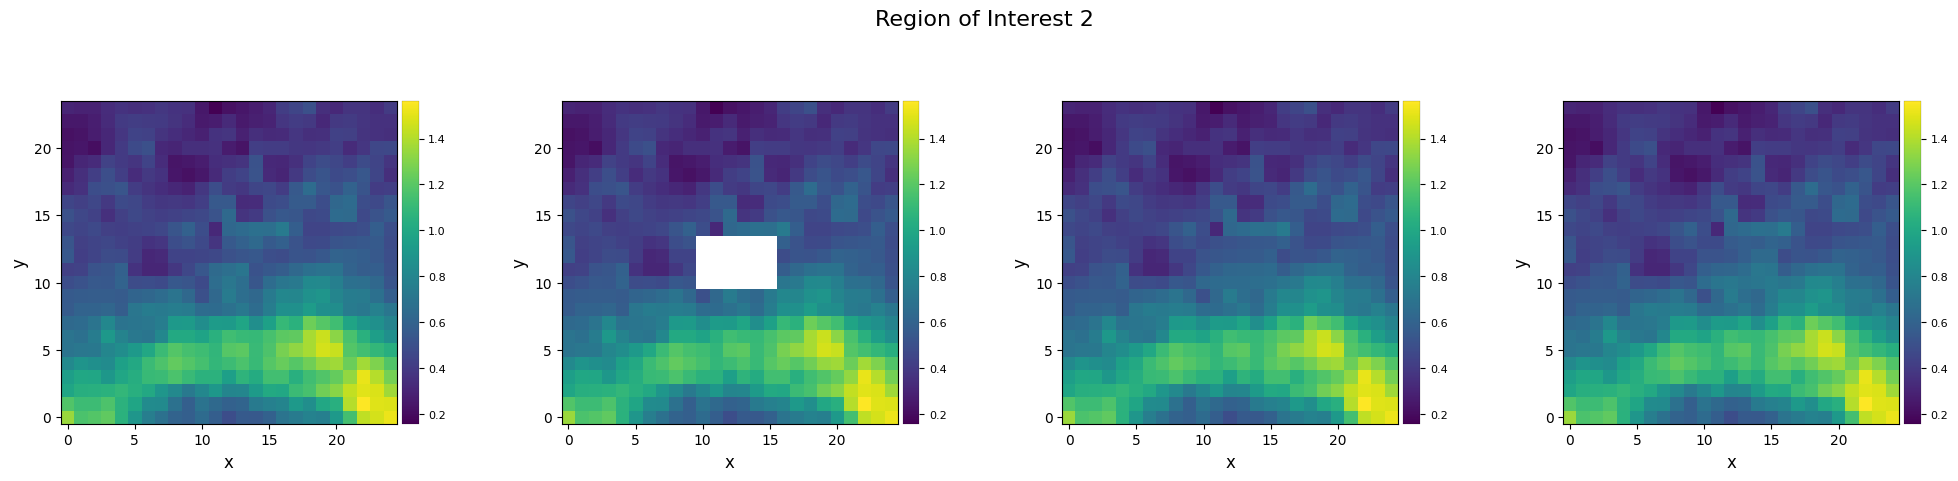

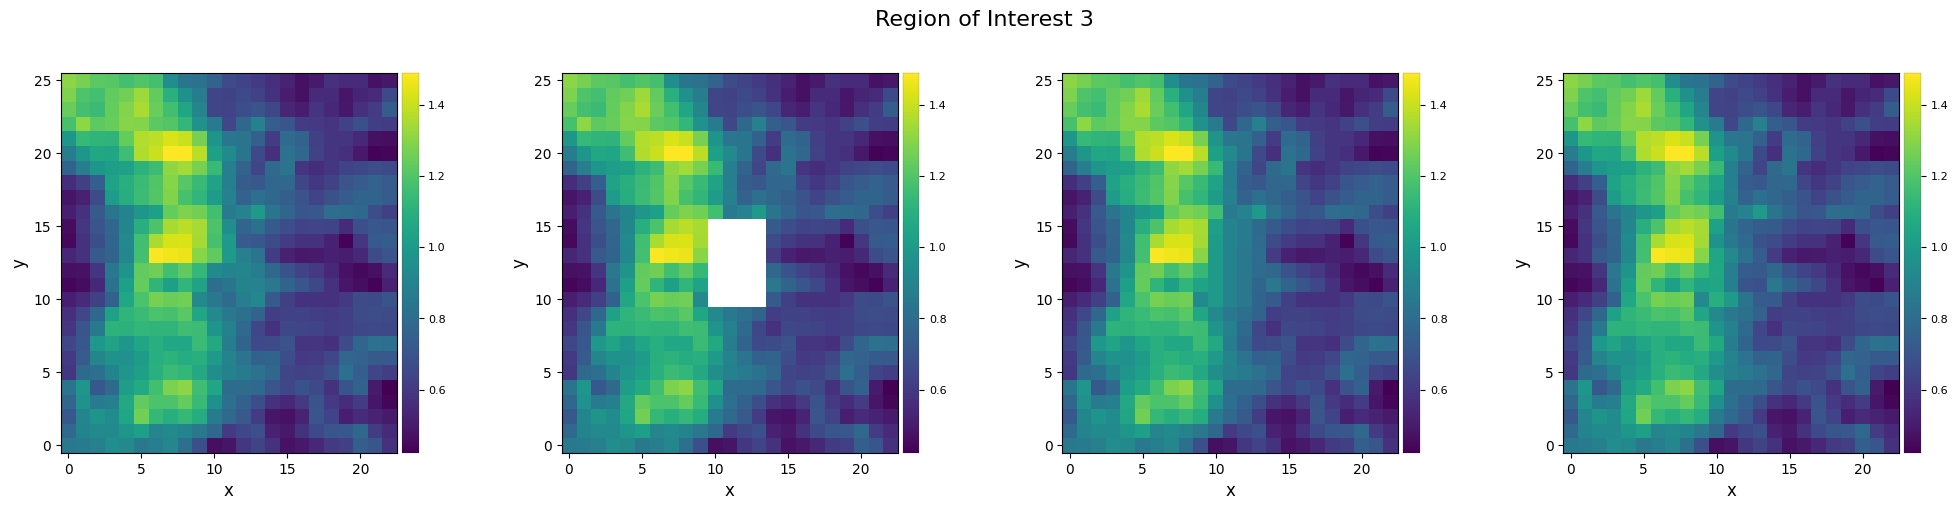

In [34]:
for t in range(len(test_idx)):
    roi_y0, roi_y1 = ty0[t] - 10, ty1[t] + 10
    roi_x0, roi_x1 = tx0[t] - 10, tx1[t] + 9
    if t == 0:
        title = "Region of Interest 1: (left) Original, (middle-left) Masked area, (middle-right) sigma-filtering median-neighbour correction, (right) DFT-based clump correction"
    else:
        title = "Region of Interest {}".format(t+1)
    plot_frames((cube_nancorr[test_idx[t],roi_y0:roi_y1,roi_x0:roi_x1],
                 frames_nan[t][roi_y0:roi_y1,roi_x0:roi_x1],
                 frames_sigcorr[t][roi_y0:roi_y1,roi_x0:roi_x1],
                 frames_fftcorr[t][roi_y0:roi_y1,roi_x0:roi_x1]), 
                title=title,
                vmin=np.nanmin(cube_nancorr[test_idx[t],roi_y0:roi_y1,roi_x0:roi_x1]),
                vmax=np.nanmax(cube_nancorr[test_idx[t],roi_y0:roi_y1,roi_x0:roi_x1]))

The algorithm doesn't magically recover the original values but makes a good guess, in particular where some low spatial frequency signal (e.g. the wing of a PSF) is present.
In the pure background noise regime, it doesn't behave significantly better than a Gaussian kernel interpolation (see example in Sec. 2.3.) - and the latter is recommended for its speed.

Note that `cube_fix_badpix_ifs` would have been another option to correct for bad pixels in this IFS dataset, provided that the images are already aligned with respect to each other.

### 2.2.4. Background-star removal

Now let's remove the background star for a good 2D fit of all satellite spots.

```{note}
A background star overlapping with a satellite spot is an uncommon issue, feel free to skip directly to [Sec. 2.2.5](#2.2.5.-Satellite-spot-based-recentering) if you do not have to deal with this issue, or are only interested in the recentering part.
```

In [35]:
cube_corr = cube_sigcorr

We'll use the non-coronagraphic PSF observed during the same night to subtract the background star. Let's first normalize the observed non-coronagraphic PSF to an integrated flux of 1 within 1 FWHM. By default the FWHM is found by fitting a 2D Gaussian model with the `normalize_psf` function:

In [36]:
from vip_hci.fm import normalize_psf

In [37]:
%matplotlib inline
crop_sz = 15
norm_psf, flux, fwhm = normalize_psf(psfifs, fwhm='fit', full_output=True, size=crop_sz)

Mean FWHM per channel: 
[5.2   5.227 5.23  5.245 5.287 5.327 5.357 5.378 5.398 5.418 5.481 5.552
 5.599 5.627 5.657 5.689 5.73  5.787 5.828 5.85  5.868 5.857 5.804 6.105
 6.362 6.23  6.225 6.255 6.3   6.349 6.39  6.423 6.444 6.491 6.539 6.592
 6.659 6.727 6.787]
Flux in 1xFWHM aperture: 
[ 4999.616  8605.83  10904.33  12126.272 13194.393 14388.846 15444.562
 15987.688 14864.771 12628.708 12302.344 14227.798 16315.584 17630.115
 18578.563 19438.338 20021.445 20474.703 20939.023 20619.506 18458.71
 13514.223  7473.132  3730.324  3097.108  4777.345  7698.074 10945.942
 14079.887 17093.565 20077.491 22889.499 25092.631 26571.491 27175.983
 27369.823 27411.929 27244.554 26593.662]


Now let's measure the approximate position of the BKG star in the median image of the spectral cube:

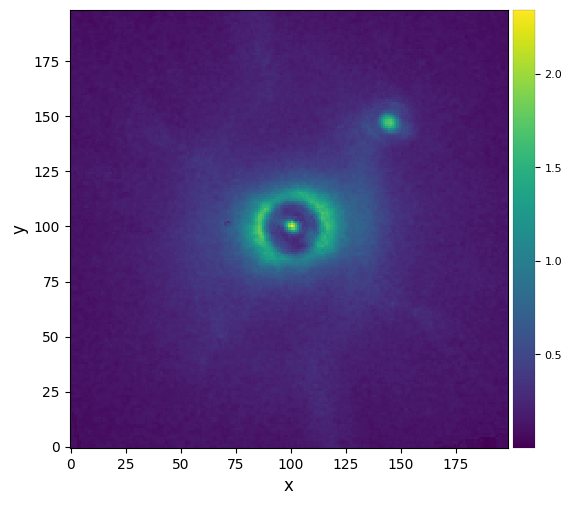

In [38]:
median_fr = np.nanmedian(cube_corr, axis=0)
plot_frames(median_fr)#, backend='bokeh')

The approximate position is:

In [39]:
bkg_xy = (144, 147)

To refine the position of the background star, let's fit a 2D Gaussian to the median frame (the `debug` option enables to check the residuals after model subtraction):

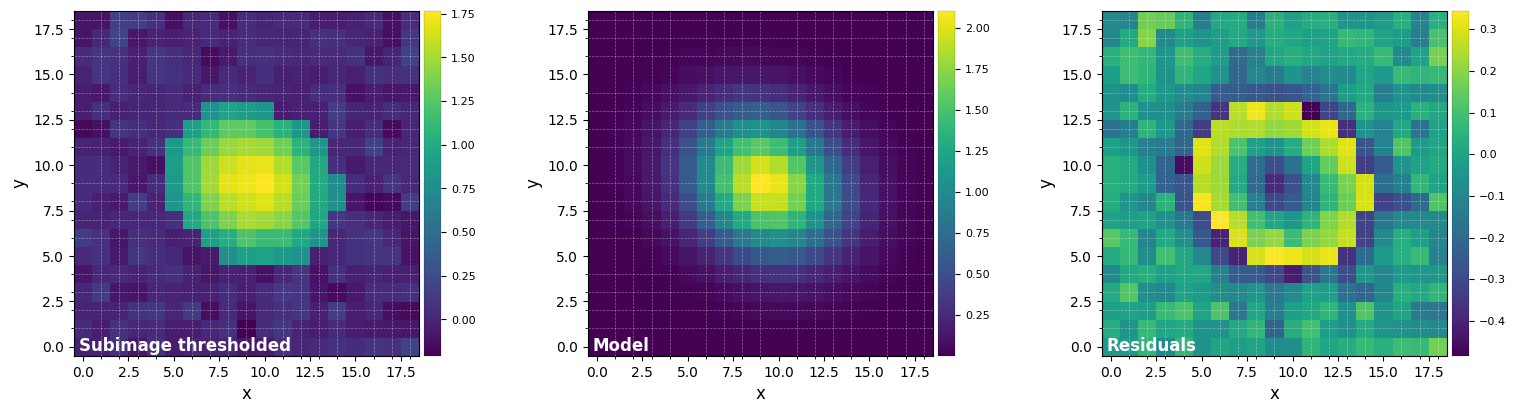

FWHM_y = 5.668793050379847
FWHM_x = 6.764571998190242 

centroid y = 147.02029148789367
centroid x = 144.2886804312188
centroid y subim = 9.020291487893676
centroid x subim = 9.288680431218802 

amplitude = 2.115277029561246
theta = -213.74096844154562


In [40]:
from vip_hci.var import fit_2dgaussian  # var is a sub-package with various utility routines

med_y, med_x = fit_2dgaussian(median_fr, crop=True, cent=bkg_xy, cropsize=19, threshold=True, 
                              sigfactor=4, full_output=False, debug=True)

Let's also try to fit a 2D Gaussian to the individual spectral frames - now using the `full_output` option to retrieve all parameters of the fit:

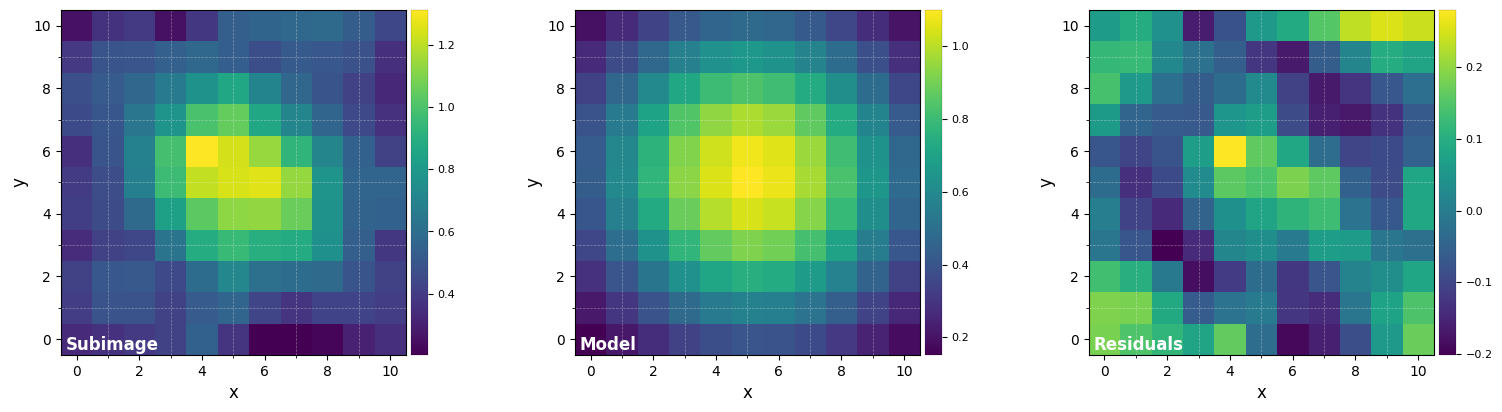

FWHM_y = 8.660307473401705
FWHM_x = 8.924782750245273 

centroid y = 147.23911854827043
centroid x = 144.1526625208313
centroid y subim = 5.239118548270438
centroid x subim = 5.152662520831313 

amplitude = 1.1032486182399754
theta = -23.162856641608577


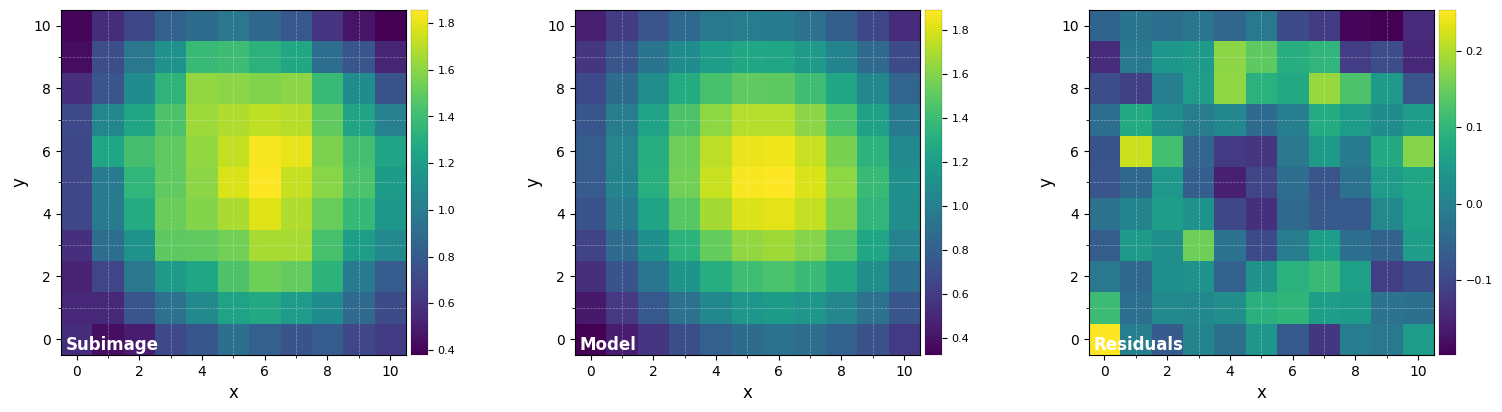

FWHM_y = 9.544127081132364
FWHM_x = 10.373896190867667 

centroid y = 147.15558384643563
centroid x = 144.6347396144857
centroid y subim = 5.155583846435644
centroid x subim = 5.6347396144857145 

amplitude = 1.901320547133558
theta = 313.7354704176627


In [41]:
fit_xy = np.zeros([cube.shape[0], 2])
fit_fwhm = np.zeros([cube.shape[0], 2])
fit_amp = np.zeros([cube.shape[0]])
fit_theta = np.zeros([cube.shape[0]])
for z in range(cube.shape[0]):
    if z == 0 or z == cube.shape[0]-1:
        # to avoid too many plots, let's just check the residuals for the first and last spectral frame
        debug = True
    else:
        debug = False
    res = fit_2dgaussian(cube_corr[z], crop=True, cent=(med_x, med_y), cropsize=11,
                         threshold=False, sigfactor=0.5, full_output=True, debug=debug)
    fit_xy[z,0] = float(res['centroid_x'].iloc[0])
    fit_xy[z,1] = float(res['centroid_y'].iloc[0])
    fit_fwhm[z,0] = float(res['fwhm_x'].iloc[0])
    fit_fwhm[z,1] = float(res['fwhm_y'].iloc[0])
    fit_amp[z] = float(res['amplitude'].iloc[0])
    fit_theta[z] = float(res['theta'].iloc[0])

Let's plot the x,y positions found by the fits:

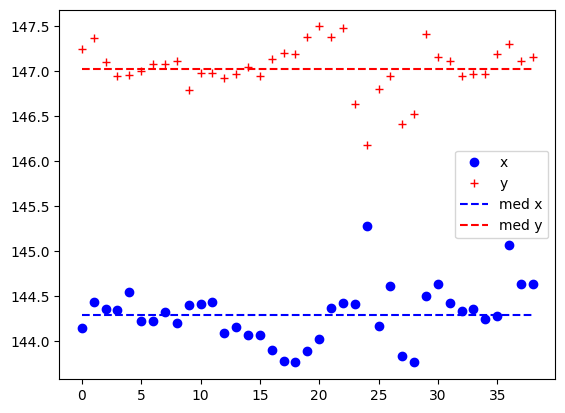

In [42]:
cols = ['b', 'r']
marks = ['o', '+']
plt.plot(range(cube.shape[0]), fit_xy[:,0], cols[0]+marks[0], label = 'x')
plt.plot(range(cube.shape[0]), fit_xy[:,1], cols[1]+marks[1], label = 'y')
plt.plot(range(cube.shape[0]), [med_x]*cube.shape[0], cols[0]+'--', label = 'med x')
plt.plot(range(cube.shape[0]), [med_y]*cube.shape[0], cols[1]+'--', label = 'med y')
plt.legend()

Although the residual images do not show any obvious bias by the nearby satellite spot this time, the estimated position changes by up to ~1-2 px. It is unclear whether this is due to noisy data or actual jittering. 

Let's use the `normalize_psf` function again, this time to measure the flux in each spectral channel at the location of the BKG star. Before that we provide a sub-cube, centered at the median location of the BKG star. Internally, a step of recentering is performed (with 2D Gaussian fits similar to above) before measuring the flux in 1-FWHM radius apertures. Note that this time we fixed the value of `fwhm` in each spectral channels to the values found previously with the non-coronagraphic PSF:

In [43]:
from vip_hci.preproc import cube_crop_frames

subcube = cube_crop_frames(cube, size=13, xy=(med_x, med_y))
res = normalize_psf(subcube, fwhm=fwhm, threshold=None, full_output=True, verbose=True, debug=True)
fit_flux = res[1]

New shape: (39, 13, 13)
Flux in 1xFWHM aperture: 
[22.274 27.988 30.231 32.978 33.926 35.492 36.131 35.786 33.806 32.51
 33.515 35.477 38.082 40.757 39.925 40.084 42.377 43.566 43.317 43.937
 43.55  38.84  30.284 26.018 27.192 30.244 34.278 39.913 43.786 46.135
 48.691 49.838 51.637 53.332 54.734 55.714 56.277 56.607 57.52 ]


Let's plot the flux inferred for the BKG star:

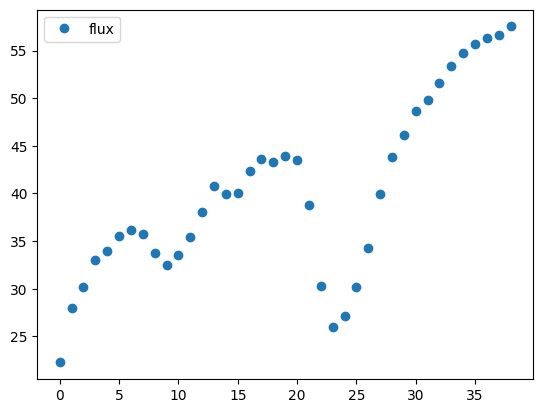

In [44]:
cols = ['b', 'r']
marks = ['o', 'D']
plt.plot(range(cube.shape[0]), fit_flux[:], marks[0], label = 'flux')
plt.legend()

This is the flux in detector units measured after considering transmission from the atmosphere, telescope and instrument. The main dips in this spectrum are due to atmospheric water absorption bands.

Now let's use this flux to scale the normalized PSF and subtract it to each frame of the cube:

In [45]:
from vip_hci.fm import frame_inject_companion

for z in range(cube.shape[0]):
    cube[z] = frame_inject_companion(cube_corr[z], norm_psf[z], med_y, med_x, -fit_flux[z],
                                     imlib='vip-fft', interpolation='lanczos4')

Let's check the result of the subtraction in a few frames:

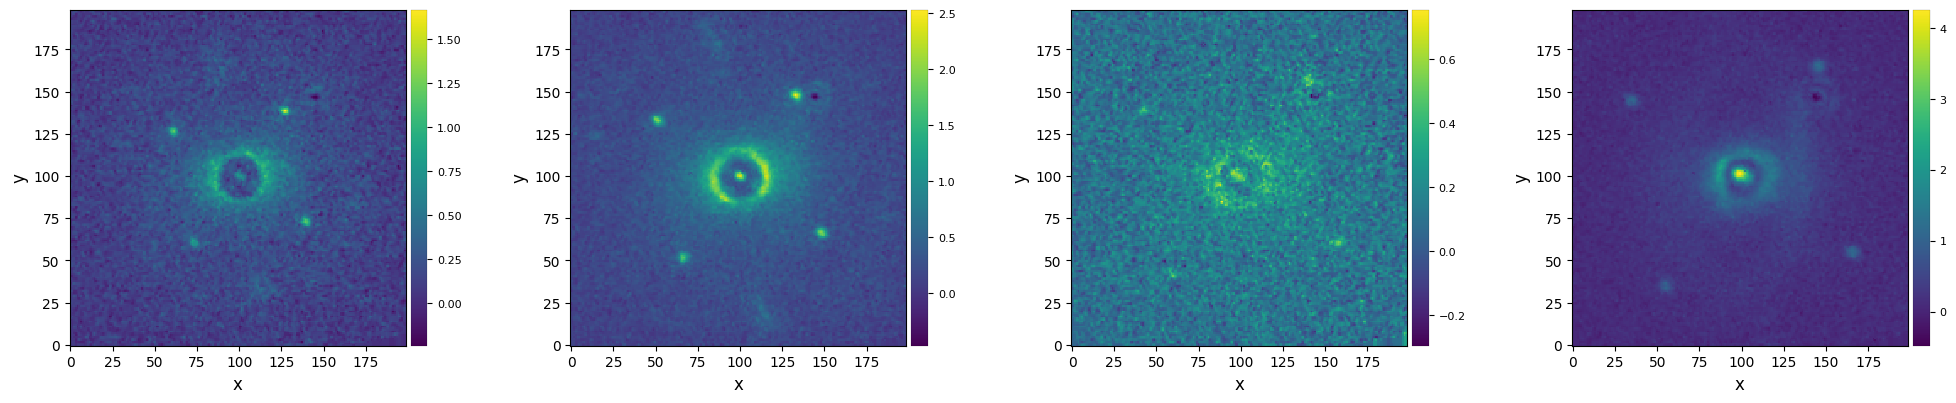

In [46]:
%matplotlib inline
plot_frames((cube[0], cube[13], cube[25], cube[-1]))#, backend='bokeh')


Although the subtraction is not perfect (the Airy ring is not well fitted, hence the core is a bit oversubtracted), it should be enough for the purpose of using the satellite-spots for recentering.

### 2.2.5. Satellite-spot based recentering

Recentering based on satellite spots is as simple as calling the `cube_recenter_satspots` function, providing the approximate position `xy` of the satellite spots in the *first* spectral channel and the wavelength vector `lbda`.

In [47]:
xy = ((61,126), (127,138), (73,60), (140,72))

Depending on your images, you may have to play with the size of the subimages `subi_size` where the 2D fit is peformed, the thresholding (`sigfactor`) or adapt the `fit_type` ('moff' or 'gaus').
Set `debug` to True to actually see each 2D Moffat or Gaussian fit (warning: in this case 4x39 Gaussian fits are performed and shown!).

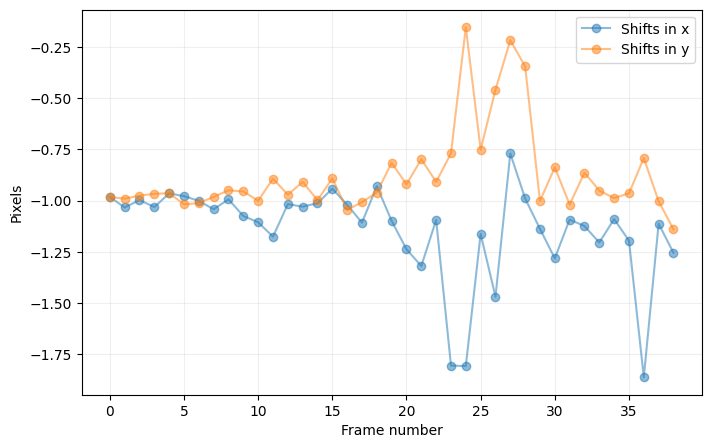

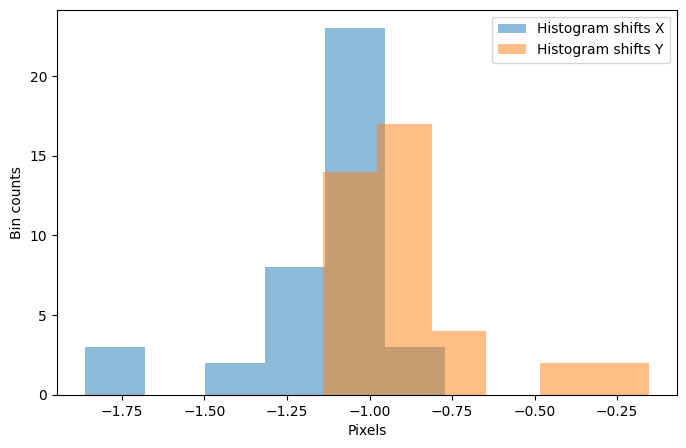

In [48]:
from vip_hci.preproc import cube_recenter_satspots

res = cube_recenter_satspots(cube, xy, lbda=lbda, 
                             subi_size=9, sigfactor=0., fit_type='gaus', 
                             plot=True, border_mode='constant', 
                             debug=False, verbose=False, full_output=True)
cube_sats, shift_y, shift_x, sat_y, sat_x= res

There appears to be a few outliers. Let's confirm this with the inspection of the central area of each frame:

New shape: (39, 141, 141)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

:Dataset   [x,y,time]   (flux)
:Cube_shape	[141, 141, 39]


:DynamicMap   [time]
   :Image   [x,y]   (flux)
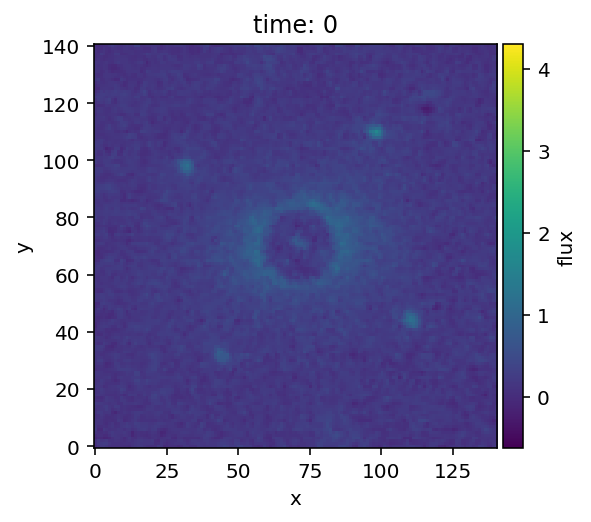

In [49]:
from vip_hci.preproc import cube_crop_frames

plot_cubes(cube_crop_frames(cube, 141))#, backend='bokeh')  # we plot a cropped version of the cube

Inspection of the corresponding images shows that the flux of the satellite spots is almost null in these channels (in the atmosphere's water absorption band). One can either make the assumption that the shift is the same at all wavelengths, or interpolate from the values found in bright spectral channels.

In [50]:
med_sh_y = np.median(shift_y)
med_sh_x = np.median(shift_x)
print("Median shifts (xy):", med_sh_x, med_sh_y)

Median shifts (xy): -1.0926264667514118 -0.9607412976221354


Note that the same function can be used for recentering of IRDIS images using satellite spots.

### 2.2.6. Radon-transform based recentering

This method relies on the Radon transform, the relevant image transformation to exploit the radial information present in broad-band (or spectrally averaged) images, in order to find the location of the star. More details are available in [Pueyo et al. (2015)](https://ui.adsabs.harvard.edu/abs/2015ApJ...803...31P/abstract).

In [51]:
mean_fr = np.mean(cube[:30], axis=0) #we skip the last channels where the BKG PSF was the most poorly subtracted

To improve the performance of the Radon-transform based algorithm, it is important to high-pass filter the input frame:

In [52]:
mean_fr_hpf = vip.var.frame_filter_highpass(mean_fr, mode='gauss-subt', fwhm_size = 2*np.mean(fwhm))

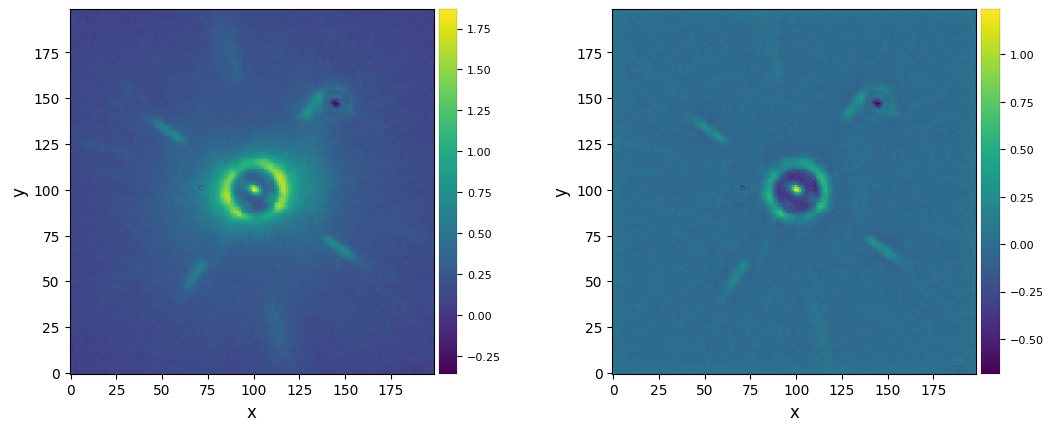

In [53]:
%matplotlib inline
plot_frames((mean_fr,mean_fr_hpf))

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-10-25 12:49:42
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
*** Iteration 1/2 ***


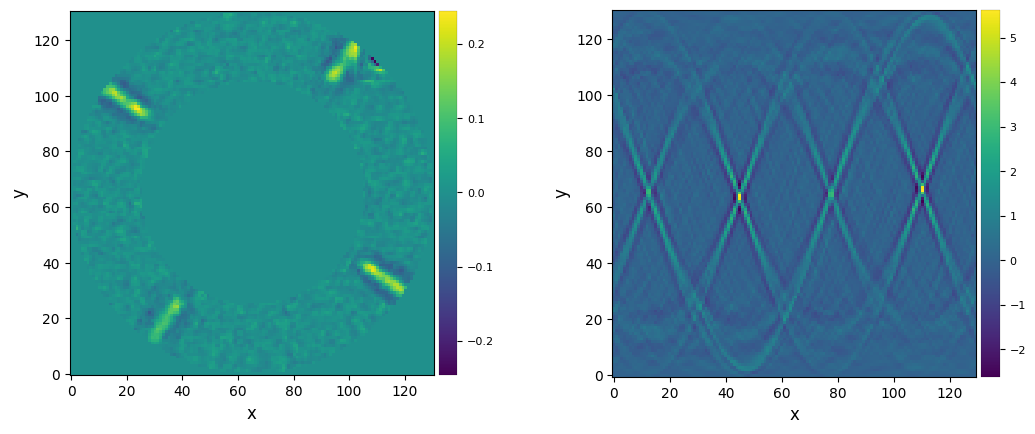

Done 961 radon transform calls distributed in 5 processes


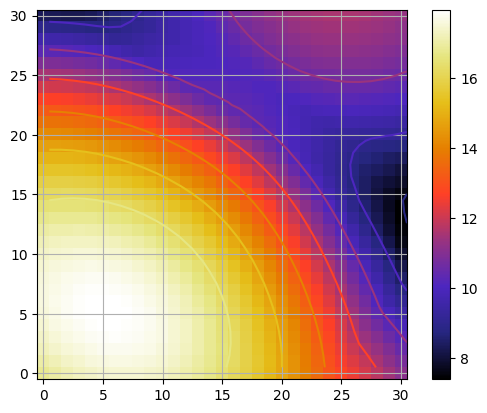

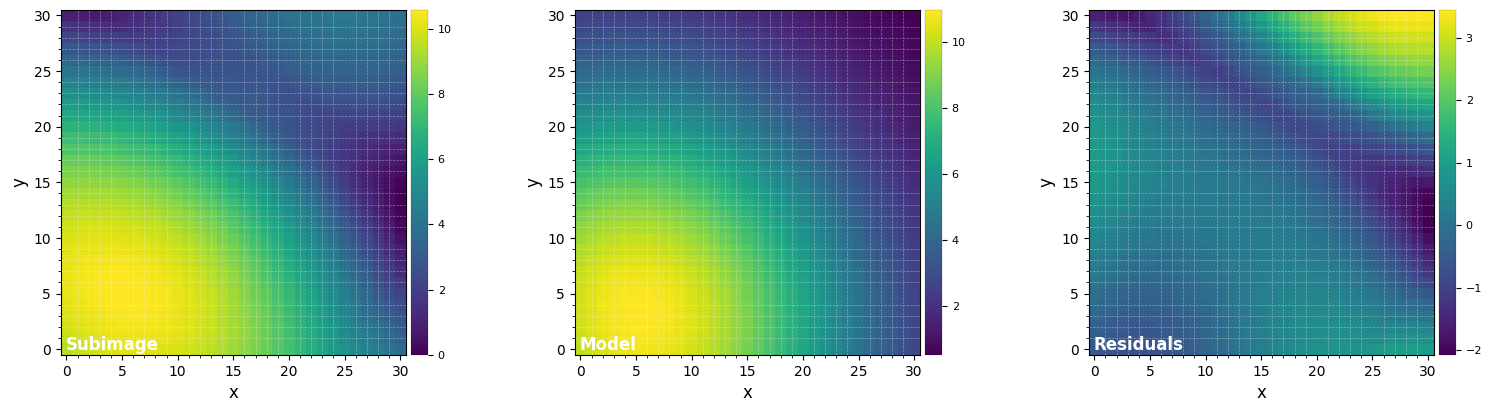

FWHM_y = 34.11740521020697
FWHM_x = 37.61570302358657 

centroid y = 3.299056965899722
centroid x = 5.410678330469957
centroid y subim = 3.299056965899722
centroid x subim = 5.410678330469957 

amplitude = 10.965888765680017
theta = 296.92156225377136
Cost function max: 17.969803106264095
Finished grid search radon optimization: dy=-1.170, dx=-0.959
Running time:  0:00:04.432643
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
*** Iteration 2/2 ***


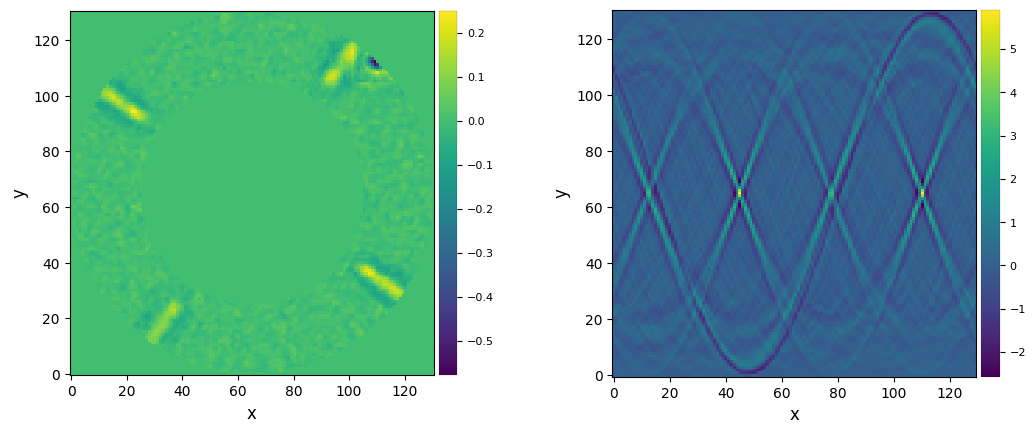

Done 900 radon transform calls distributed in 5 processes


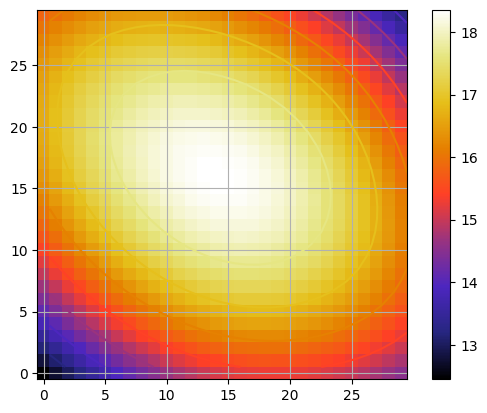

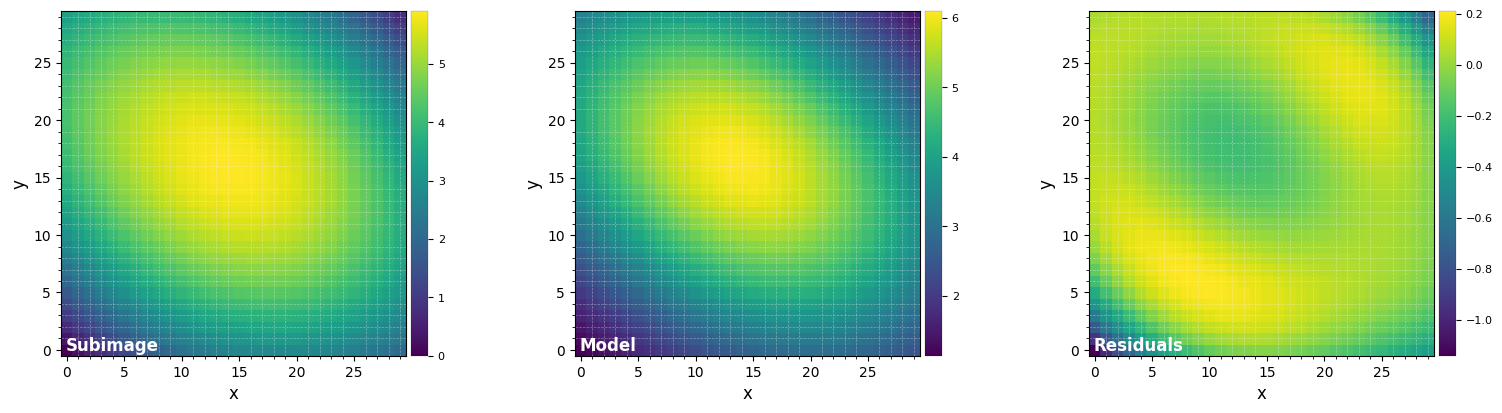

FWHM_y = 40.27337807592116
FWHM_x = 27.4131389387971 

centroid y = 16.43874652285045
centroid x = 13.64927926121357
centroid y subim = 16.43874652285045
centroid x subim = 13.64927926121357 

amplitude = 6.102205077002089
theta = -484.20916153012496
Cost function max: 18.357497701647844
Finished grid search radon optimization: dy=0.108, dx=-0.101
Running time:  0:00:08.790242
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Star (x,y) location: 97.94, 97.94
Final (x,y) shifts: -1.06, -1.06


In [54]:
from vip_hci.preproc import frame_center_radon

opt_y, opt_x = frame_center_radon(mean_fr_hpf, cropsize=131, hsize_ini=1.5, step_ini=0.1, mask_center=40, 
                                  nproc=None, satspots_cfg=None, full_output=False, verbose=True, n_iter=2,
                                  tol=0.05, plot=True, debug=True)

Several iterations can be made through the `n_iter` parameter. Although as seen above, in this case a single iteration was enough - as the second iteration yields (almost) null additional shifts.

Note that one can increase the precision of the algorithm, by decreasing the `step` used in the grid.

In [55]:
from vip_hci.var import frame_center

cy, cx = frame_center(mean_fr)

print("Estimated star coordinates (xy):", opt_x, opt_y)
print("Estimated shifts (xy):", cx-opt_x, cy-opt_y)

Estimated star coordinates (xy): 97.939763777638 97.93781168580375
Estimated shifts (xy): 1.0602362223619934 1.0621883141962485


```{note}
`frame_center` is a convenience function returning the center coordinates of an image, defined in the `var` sub-package which contains various utility routines defining shapes, 2D fitting functions, spatial filters, or coordinate conversion functions.
```

As expected, the Radon-transform based algorithm found similar shift values as the satellite-spot based one, since the most prominent features driving the centering are the wavelength-smeared satellite spots.

Once the stellar centroid found, it is only a matter of shifting each frame of the cube with the same xy shifts:

In [56]:
from vip_hci.preproc import cube_shift

cy, cx = frame_center(mean_fr)
cube = cube_shift(cube_corr, cy-opt_y, cx-opt_x)

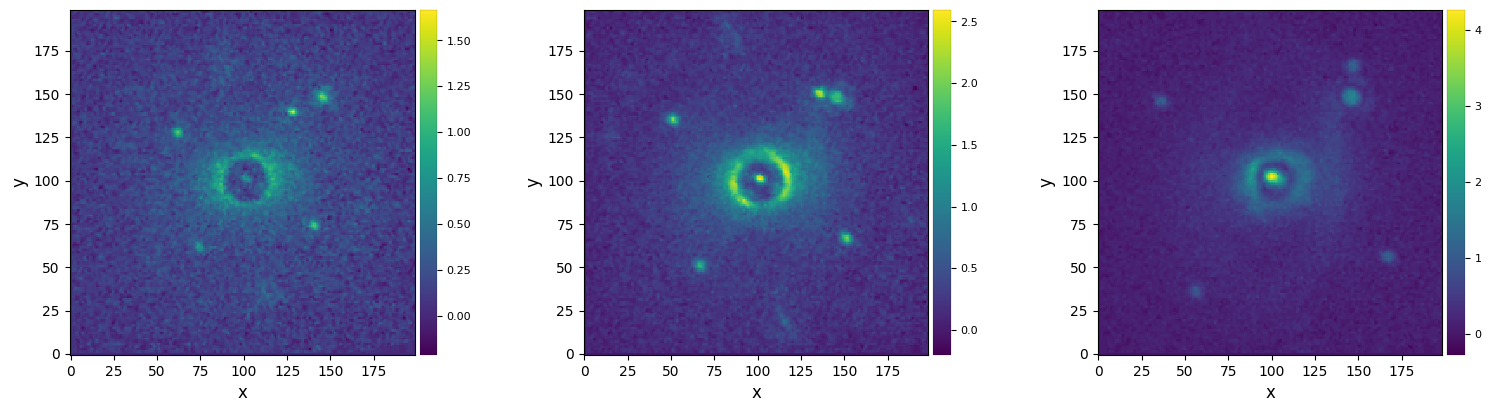

In [57]:
plot_frames((cube[0], cube[15], cube[-1]))

## 2.3. Pre-processing a SINFONI datacube

### 2.3.1. Loading the data

In the 'datasets' folder of the `VIP_extras` repository you can find a SINFONI datacube obtained on HD 179218 in May 2014. The star did not saturate and no coronagraph was used.

The point of this section is to show how to:

- correct for residual bad pixels in images where the vertical sampling is half of the horizontal sampling;
- resample images vertically;
- perform a fine recentering of the images based on 2D Gaussian fits.

In [58]:
from vip_hci.fits import open_fits

url_d = "https://github.com/vortex-exoplanet/VIP_extras/raw/master/datasets"
f1 = download_file("{}/sinfoni_HD179218_cube.fits".format(url_d), cache=True)
f2 = download_file("{}/sinfoni_HD179218_lbda.fits".format(url_d), cache=True)

# alternatively, for local files simply provide their full or relative path. E.g.:
#f1 = '../datasets/sinfoni_HD179218_cube.fits'
#f2 = '../datasets/sinfoni_HD179218_lbda.fits'

cube = open_fits(f1)
lbda = open_fits(f2)

FITS HDU-0 data successfully loaded. Data shape: (400, 64, 64)
FITS HDU-0 data successfully loaded. Data shape: (400,)


Each original spectral cube consisted of ~2000 monochromatic images spread in wavelengths over the H and K bands.

Given the large size of typical full SINFONI observations, in this tutorial we only include one datacube, obtained after calibration using the ESO pipeline (including dark subtraction, flat-fielding, sky subtraction, wavelength calibration and 3D spectral cube synthesis), and after cropping the cube to only keep the last 400 channels. Note that  the procedure below would be identical with a non-cropped cube.

Let's first visualize a few images from the datacube:

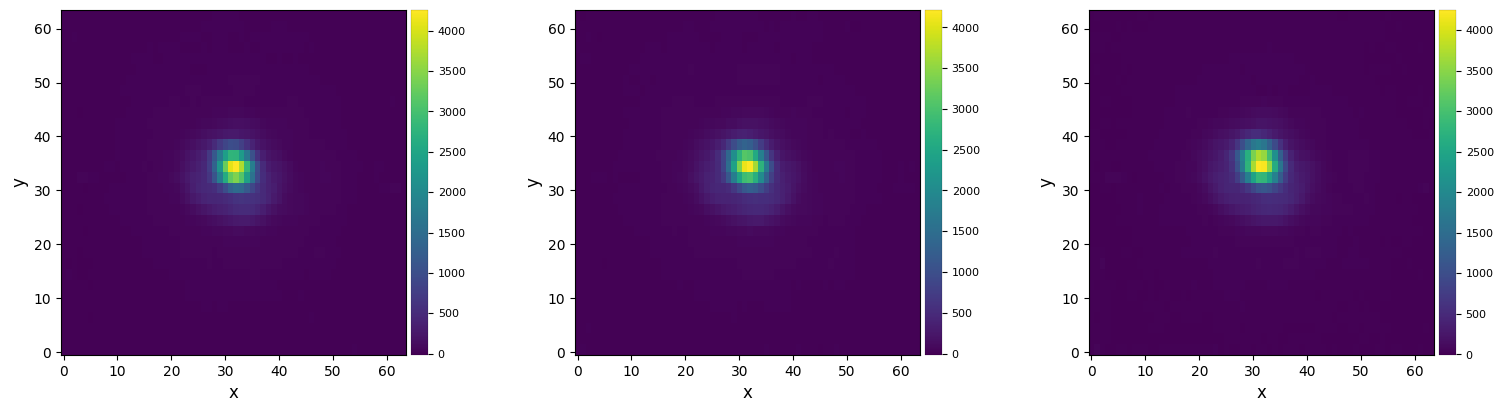

In [59]:
plot_frames((cube[1], cube[200], cube[-1]))

A couple of things can be noted from the inspection of the images:

- the PSF is not centered and expands radially with increasing wavelength;
- the vertical sampling of pixels is half that of the horizontal sampling (i.e. every pair of rows is identical);
- there are bad pixels in the images (best seen with harsher cuts) which tend to come as clumps or horizontal streaks.

We will therefore proceed with:

1. Measuring the FWHM of the PSF in each frame;
2. identifying and correcting bad pixels;
3. resample the images vertically;
4. recenter the cube based on 2D Gaussian fits.

### 2.3.2. FWHM measurement

As seen previously, the FWHM can be easily measured in each frame using the `normalize_psf` function. Let's first consider a 2D Gaussian fit to the mean image, in order to find the average position of the star:

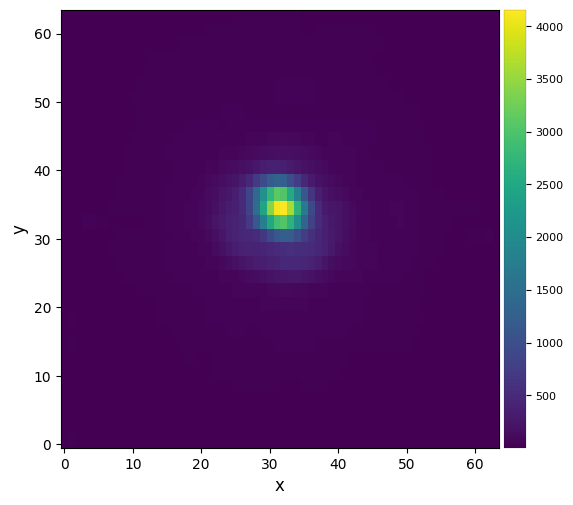

In [60]:
mean_fr = np.mean(cube,axis=0)
plot_frames(mean_fr)

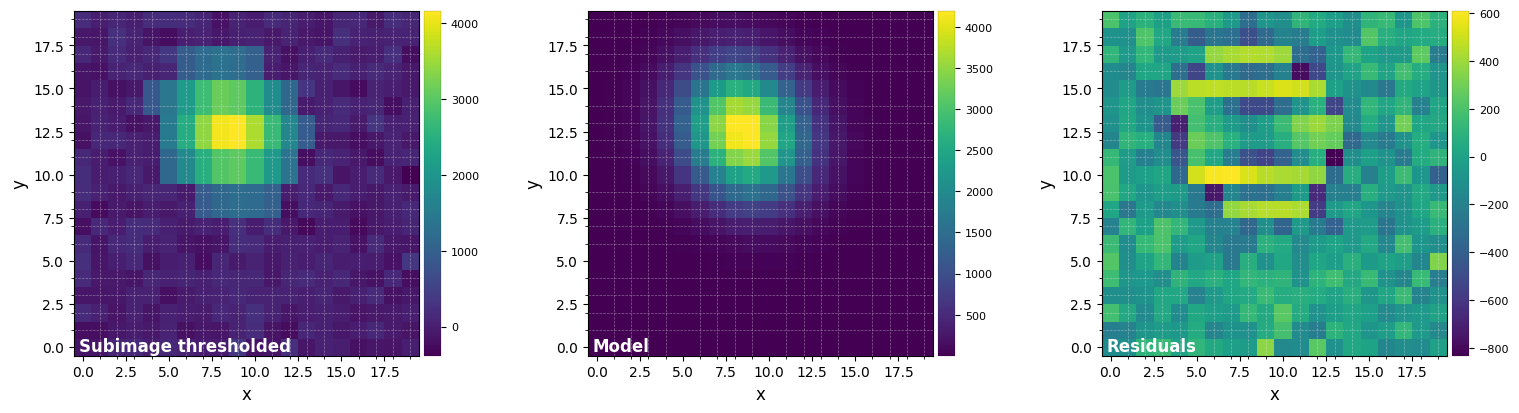

FWHM_y = 5.217311898193579
FWHM_x = 6.022751690913999 

centroid y = 34.549492809840224
centroid x = 31.548242548462397
centroid y subim = 12.549492809840226
centroid x subim = 8.548242548462397 

amplitude = 4364.445747984314
theta = 118.89208918114223


In [61]:
mean_y, mean_x = fit_2dgaussian(mean_fr, crop=True, cent=(33,32), cropsize=20, threshold=True, 
                                sigfactor=5, full_output=False, debug=True)

Now let's consider a sub-cube centered on the mean position, and use `normalize_psf` to measure FWHM and flux:

In [62]:
from vip_hci.fm import normalize_psf
from vip_hci.preproc import cube_crop_frames

subcube = cube_crop_frames(cube, size=21, xy=(mean_x, mean_y), force=True)  # force cropping to odd size from even size
res = normalize_psf(subcube, fwhm='fit', full_output=True)
norm_psf, fluxes, fwhm = res

New shape: (400, 21, 21)
Mean FWHM per channel: 
[6.585 6.606 6.59  6.593 6.579 6.58  6.594 6.583 6.598 6.591 6.593 6.593
 6.593 6.602 6.588 6.6   6.595 6.61  6.593 6.593 6.602 6.584 6.595 6.606
 6.603 6.598 6.593 6.613 6.593 6.604 6.613 6.61  6.608 6.595 6.609 6.608
 6.594 6.616 6.608 6.625 6.592 6.619 6.625 6.604 6.629 6.605 6.615 6.606
 6.618 6.633 6.602 6.637 6.62  6.636 6.619 6.629 6.619 6.613 6.633 6.615
 6.624 6.634 6.62  6.63  6.618 6.626 6.628 6.621 6.629 6.62  6.631 6.635
 6.627 6.634 6.636 6.629 6.64  6.646 6.646 6.629 6.631 6.633 6.639 6.647
 6.633 6.644 6.645 6.64  6.637 6.627 6.637 6.639 6.638 6.656 6.633 6.663
 6.651 6.641 6.652 6.637 6.656 6.647 6.66  6.64  6.633 6.659 6.667 6.66
 6.654 6.65  6.66  6.652 6.663 6.652 6.655 6.664 6.666 6.664 6.649 6.659
 6.667 6.657 6.662 6.667 6.668 6.675 6.678 6.669 6.668 6.657 6.661 6.666
 6.675 6.663 6.677 6.671 6.68  6.661 6.665 6.678 6.676 6.675 6.676 6.683
 6.669 6.697 6.686 6.687 6.677 6.675 6.68  6.691 6.689 6.698 6.678 6.702
 6.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### 2.3.3. Bad pixel correction

Several bad pixel correction algorithms are available in VIP:

1. `cube_fix_badpix_isolated`: to correct isolated bad pixels by sigma filtering;
2. `cube_fix_badpix_annuli`: identifies bad pixels in narrow concentric annuli (requires a circularly symmetric PSF), and can replace them with median value of the annuli (+- some Poisson noise);
3. `cube_fix_badpix_clump`: which iteratively identifies bad pixels by sigma filtering, and replace them with the median of good neighour pixels (useful for clumps of bad pixels);
4. `cube_fix_badpix_ifs`: which leverages the radial expanion of the PSF with wavelength in IFS cubes to better identify bad pixels;
5. `cube_fix_badpix_interp`: which corrects bad pixels either using a 2D Gaussian kernel or FT interpolation (requires an input bad pixel map, possibly found by one of the first 4 methods).

Since bad pixels can show up as clumps or streaks in SINFONI cubes, it is recommended to use either `cube_fix_badpix_annuli` or `cube_fix_badpix_clump` to identify them iteratively. 

In the example below, we will first consider `cube_fix_badpix_annuli` for the identification of bad pixels, and then `cube_fix_badpix_interp` to correct the identified bad pixels using a Gaussian kernel.

If the PSF core spreads over at least a few pixels, there is low risk for the algorithm to erroneously consider a PSF core pixel as bad. In noisy channels, the risk may be non-negligeable though. To prevent this risk, one can use the `protect_mask` parameter (in which case, the coordinates of the star must also be provided through the `cy` and `cx` parameters).  Let's find the approximate stellar position in each frame with the aptly-named `approx_stellar_position` function:

In [63]:
from vip_hci.preproc import approx_stellar_position

cyx = approx_stellar_position(cube, fwhm)
cy = cyx[:,0]
cx = cyx[:,1]

Let's now set the mask size to the median value of the FWHM:

In [64]:
protect_mask = np.median(fwhm)

Given the peculiar half resolution along the vertical axis of SINFONI cubes, we will also use the `half_res_y` option, which in the case of `cube_fix_badpix_annuli` will make it consider elliptical annuli in squashed images (by a factor 2 vertically) - instead of circular annuli.

A minimum threshold `min_thr` can be set to avoid correcting pure noise (which can happen in high-absorption atmospheric bands). Considering the typical pixel intensities in SINFONI cubes and the fact that they are already sky-subtracted images of our SINFONI cube, we opt for a value of -5.

In [65]:
from vip_hci.preproc import cube_fix_badpix_annuli

cube_corr, bpm_mask, annuli = cube_fix_badpix_annuli(cube, fwhm, cy=cy, cx=cx, sig=5., 
                                                     protect_mask=protect_mask, r_in_std=10, r_out_std=None, 
                                                     verbose=True, half_res_y=True, min_thr=-5, 
                                                     full_output=True)

************Frame #  0  *************
centroid assumed at coords: 31.0 35.0
0  bpix in total, and  0  corrected.
************Frame #  1  *************
centroid assumed at coords: 31.0 35.0
1  bpix in total, and  1  corrected.
************Frame #  2  *************
centroid assumed at coords: 31.0 35.0
1  bpix in total, and  1  corrected.
************Frame #  3  *************
centroid assumed at coords: 31.0 35.0
0  bpix in total, and  0  corrected.
************Frame #  4  *************
centroid assumed at coords: 31.0 35.0
1  bpix in total, and  1  corrected.
************Frame #  5  *************
centroid assumed at coords: 31.0 35.0
0  bpix in total, and  0  corrected.
************Frame #  6  *************
centroid assumed at coords: 31.0 35.0
0  bpix in total, and  0  corrected.
************Frame #  7  *************
centroid assumed at coords: 31.0 35.0
0  bpix in total, and  0  corrected.
************Frame #  8  *************
centroid assumed at coords: 31.0 35.0
2  bpix in total, an

Let's visualize the total bad pixel maps (i.e. summed over all spectral channels), and an example of concentric annuli in which bad pixels are identified.

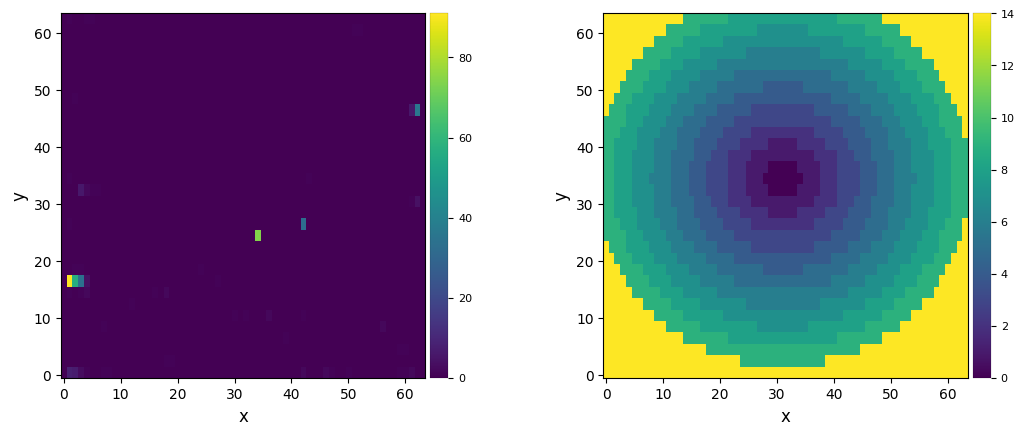

In [66]:
%matplotlib inline
plot_frames((np.sum(bpm_mask,axis=0), annuli[0]))

Let's now check one frame of the cube before and after bad pixel correction (we saturate a bit the core to better see the bad pixel):

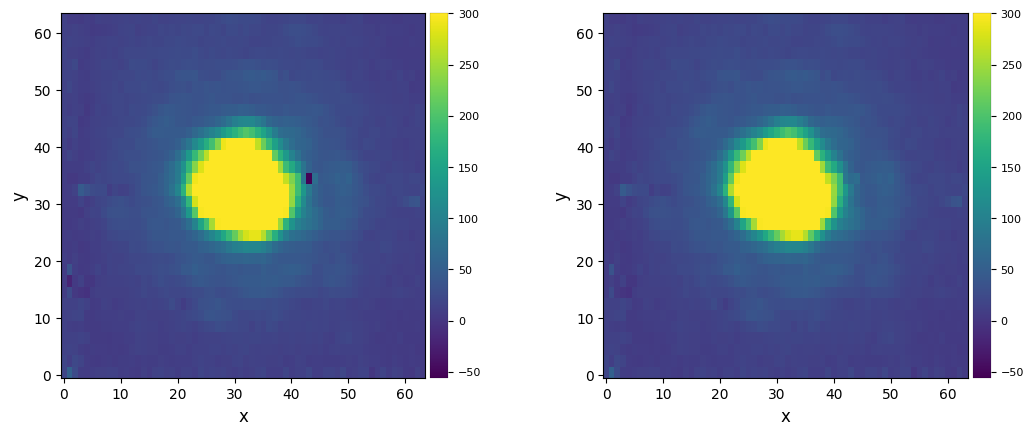

In [67]:
idx = 236
plot_frames((cube[idx], cube_corr[idx]), 
            vmin=float(np.amin(cube[idx])), vmax=300)

Let's now consider a Gaussian kernel for correction of the identified bad pixels. Note that for a better correction locally, we choose the FWHM of the Gaussian kernel to be half the FWHM of the PSF:

In [68]:
if version.parse(vvip) >= version.parse("1.3.1"):
    from vip_hci.preproc import cube_fix_badpix_interp
    cube_corr = cube_fix_badpix_interp(cube, bpm_mask, mode='gauss', fwhm=fwhm/2., half_res_y=True)
else:
    from vip_hci.preproc import cube_fix_badpix_with_kernel
    cube_corr = cube_fix_badpix_with_kernel(cube, bpm_mask, mode='gauss', fwhm=fwhm/2., half_res_y=True)

Let's check again the same frame of the cube, before and after bad pixel correction, this time with the Gaussian kernel:

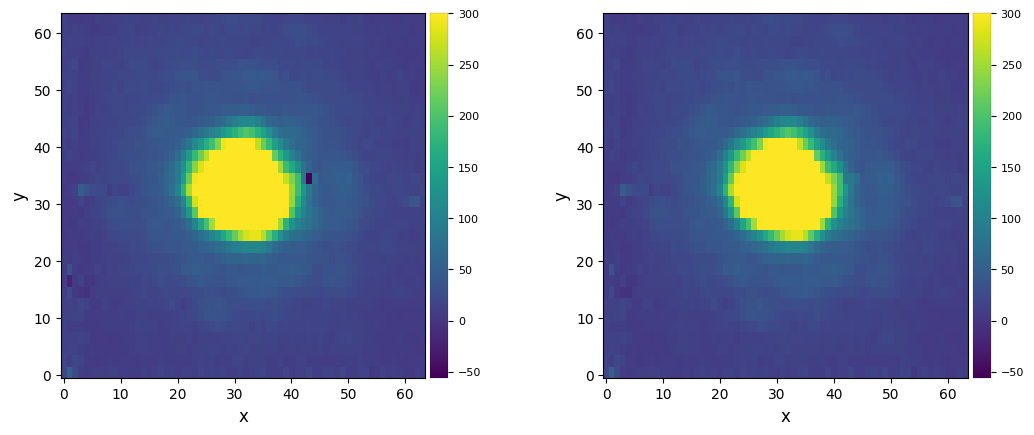

In [69]:
idx = 236
plot_frames((cube[idx], cube_corr[idx]), 
            vmin=float(np.amin(cube[idx])), vmax=300)

In this specific case, the annulus-based and Gaussian kernel-based corrections perform similarly. Keep however in mind that the best options to use for bad pixel correction will depend on your data.

### 2.3.4. Vertical resampling

Now that bad pixels are corrected, we can resample the images vertically. This can be done easily with the `cube_px_resampling` function. Before that, we first downsample the image vertically by a factor 2 (since every pair of rows is identical):

In [70]:
nz, ny, nx = cube.shape
# downsample
nny = ny//2
cube_do = np.zeros([nz, nny, nx])
for z in range(nz):
    for y in range(nny):
        cube_do[z,y] = 2*cube_corr[z,y*2]
# Note: factor 2 is for flux preservation since we are only keeping every other row.

Now let's upsample by a factor 2. It is possible to preserve the star at the center of the image with the `keep_center` option (i.e. the star centroid will continue to follow VIP's convention of being at dim//2, dim//2 even when the resampling factor converts the image from even dimensions to odd dimensions). Since the star is not yet centered, we do not use that option. The `scale` parameter can be a float (identical factor along both x and y axes) or a tuple of two values.

In [71]:
from vip_hci.preproc import cube_px_resampling

cube_up = cube_px_resampling(cube_do, scale=(1,2), imlib='ndimage', interpolation='biquintic', keep_center=False, 
                             verbose=True)

Cube successfully rescaled
New shape: (400, 64, 64)


```{note}
We used 'ndimage' instead of the default 'vip-fft' for the value of `imlib` because FFT-based image scaling is not (yet) available in the case of different scale factors along x and y. If you have installed `opencv` it is another option for image resampling (with `interpolation` set to 'lanczos4').
```

### 2.3.5. Recentering with 2D Gaussian fits

Now that the images have been correctly resampled vertically, we can accurately find the centroid of the star by fitting 2D Gaussians to each image: 

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2024-10-25 13:20:15
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
2d gauss-fitting
frames
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
Shifting
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
Running time:  0:00:01.201044
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


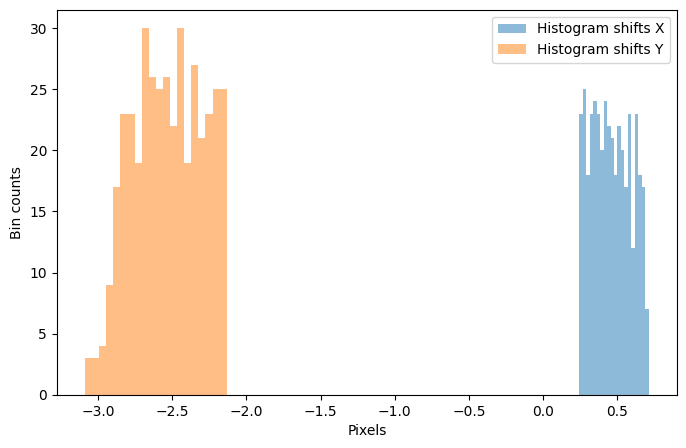

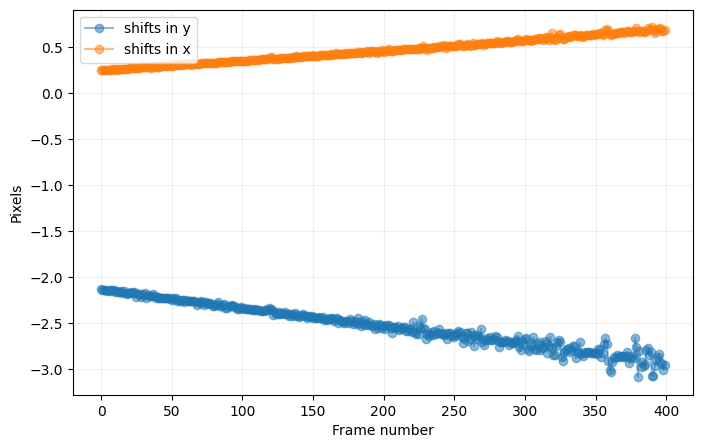

In [72]:
from vip_hci.preproc import cube_recenter_2dfit

crop_sz = 20
nproc = 1
cube_cen, shifts_y, shifts_x = cube_recenter_2dfit(cube_up, xy=(int(mean_x), int(mean_y)), 
                                               fwhm=fwhm, subi_size=crop_sz,
                                               model='gauss', nproc=nproc, 
                                               imlib='vip-fft', interpolation=None,
                                               full_output=True, plot=True)

Let's compare the images before and after resampling+recentering:

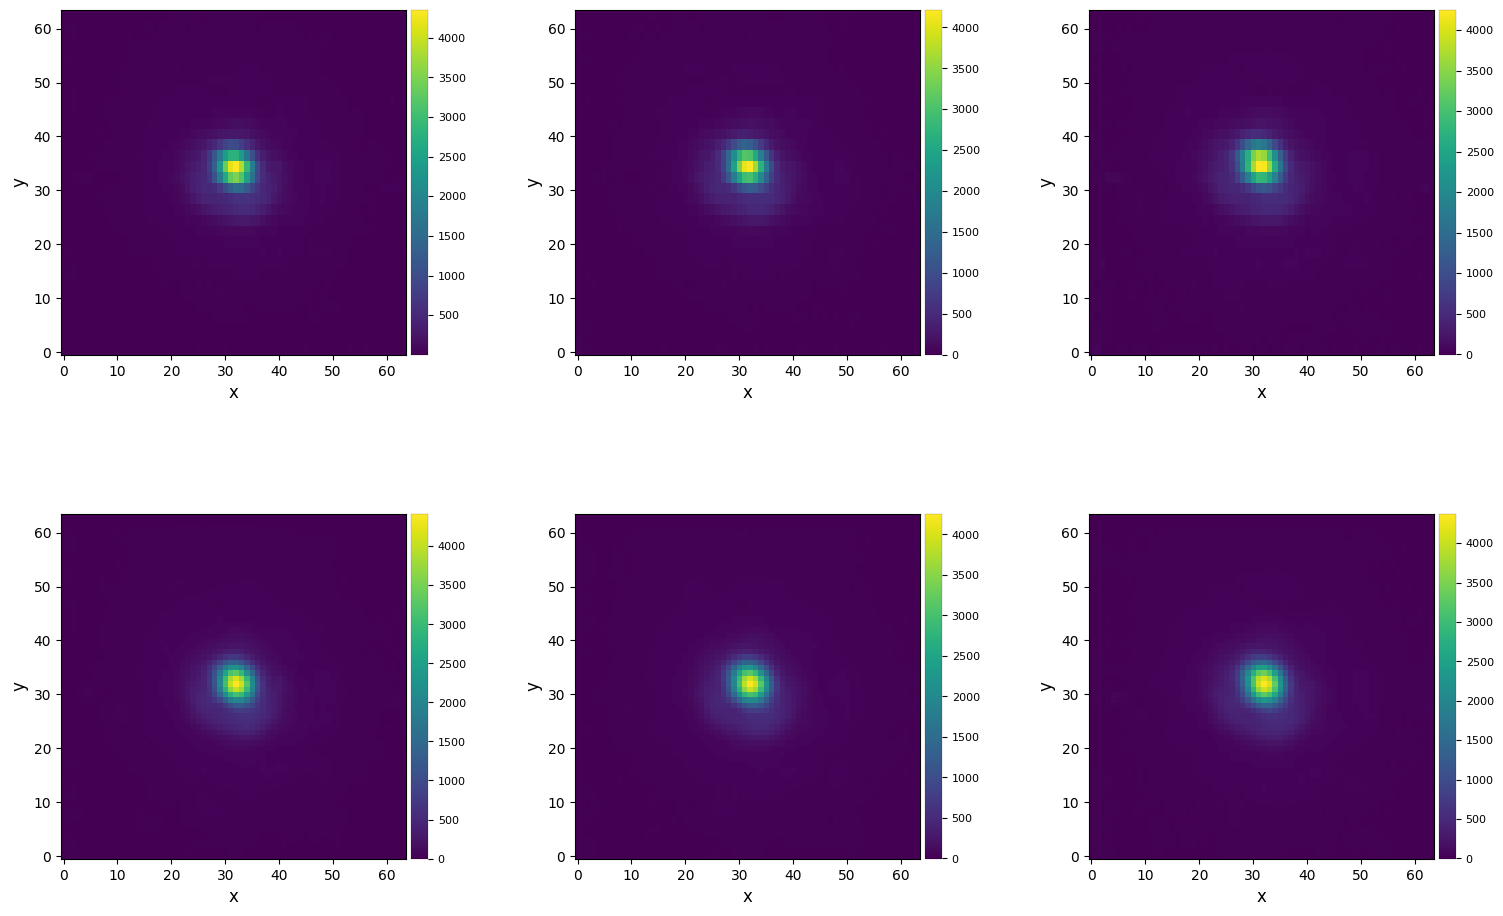

In [73]:
plot_frames((cube_corr[0], cube_corr[200], cube_corr[-1],
             cube_cen[0], cube_cen[200], cube_cen[-1]), rows=2)

Finally it is worth noting that this pre-processing procedure can be further refined now that the star location is known - e.g. by correcting residual bad pixels using `cube_fix_badpix_ifs` which requires realigned cubes and knowledge of the star location.